In [182]:
import pandas as pd
import numpy as np
import requests
import time
import math
import re
import pickle
import itertools
import glob
import string

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

import gensim 
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [101]:
sns.set_style('darkgrid')

## Data
* Top Large Companies 
* Low Rated Large Companies 
* Lowly rated companies 

### Analysis
* What are the top companies doing really well? 
* From an employee standpoint, why are these the top companies? What matters to employees the most? 
* What are the companies performing poorly doing wrong? From an employee standpoint, why are these companies failing? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Topic Modeling 

### Prediction
* predict a review rating based on the incidence of certain words (ie: if you include great people, more likely to be a 5) 
    * feature engineering? bool for 'great people' or not? 

* Feature engineering: Sentiment analysis on headline - ie: pos, neut, neg headline - is this a predictor for rating as well? 

* Can we predict the rating based on text? Can be used for surveys and other text based feedback. 
* Has the sentiment at top companies stayed the same over time? 
* Classification

* Rating a company as 'desirable' or 'not desirable'
* Desirable company: 4-5 stars avg since 2019
* Not desirable: < 4 stars avg since 2019 

## Load Files 

In [102]:
"""
Takes in a list of csv files using glob 
Output: dataframe combining all csvs vertically (axis=0)
Assumes all csvs have same column names 
"""
def files_to_df(glob_csv):
    final_df = pd.DataFrame()
    
    for file in glob_csv:
        df = pd.read_csv(file)
        df = df.drop(df.columns[0], axis=1)
        final_df = pd.concat([final_df, df])
        
    return final_df

In [103]:
""" 
Load all csv files from folders 
drop each group into a dataframe 

"""
csvfiles = glob.glob('reviews/top_50_smb/' + '*.csv')
top_50_smb_reviews = files_to_df(csvfiles)

# csvfiles = glob.glob('reviews/top_large/' + '*.csv')
# top_large_reviews =  files_to_df(csvfiles)

csvfiles = glob.glob('reviews/low_ratings_finance/' + '*.csv')
low_ratings_finance_reviews =  files_to_df(csvfiles)

## General Data Exploration

In [104]:
top_50_smb_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 229
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          9030 non-null   object 
 1   headline         9025 non-null   object 
 2   date             9030 non-null   object 
 3   overall_rating   9030 non-null   float64
 4   author_position  8765 non-null   object 
 5   pros             9030 non-null   object 
 6   cons             9030 non-null   object 
dtypes: float64(1), object(6)
memory usage: 564.4+ KB


In [105]:
top_50_smb_reviews.head()

,company,headline,date,overall_rating,author_position,pros,cons
0,6sense,Love working here,2022-02-01,5.0,Frontend Developer,- Love working with my team\n- There's complet...,The meetings with US folks tend to go late at ...
1,6sense,Great Opportunity,2022-03-30,5.0,Technical Recruiter,Great mentorship opportunities and supportive ...,No cons. They are growing fast
2,6sense,"Fantastic place to learn, grow, and be heard",2022-03-14,5.0,Demand Generation Manager,Where do I even begin? I felt like I was a par...,None that I can think of!
3,6sense,Fantastic Company,2022-03-16,5.0,Tax,"Great people to work with, value employees' op...",None that I can say at this time.
4,6sense,Love it!,2022-03-14,5.0,Corporate Event Marketing Specialist,- Great compensation\r\n- Amazing benefits\r\n...,- There are a few teams that are still being b...


## Numeric Data Preprocessing 

In [161]:
# TODO maybe wrap in method 
# convert date to datetime column 
top_50_smb_reviews.date = pd.to_datetime(top_50_smb_reviews.date, format='%Y-%m-%d')
top_50_smb_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 229
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   company          9030 non-null   object        
 1   headline         9025 non-null   object        
 2   date             9030 non-null   datetime64[ns]
 3   overall_rating   9030 non-null   float64       
 4   author_position  8765 non-null   object        
 5   pros             9030 non-null   object        
 6   cons             9030 non-null   object        
 7   pros_cleaned     9030 non-null   object        
 8   year             9030 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 705.5+ KB


# Text Preprocessing

* Using Regex & NLTK libraries
* Noise Removal – Removing unnecessary characters and formatting
* Tokenization – break multi-word strings into smaller components
* Normalization – a catch-all term for processing data; this includes stemming and lemmatization
    * Upper or lowercasing
    * Stopword removal
    * Stemming – bluntly removing prefixes and suffixes from a word
    * Lemmatization – replacing a single-word token with its root

In [106]:
top_50_smb_reviews.company.unique()

array(['6sense', 'Akraya', 'Aledade', 'Apeel Sciences', 'Aprio',
       'Articulate Inc.', 'Awardco', 'BetterUp', 'Branch Insurance',
       'Calix', 'Couchbase', 'Crew Carwash', 'Digital Prospectors',
       'Domo', 'Ethos Group', 'Foresight Mental Health', 'Gong',
       'Grammarly', 'GRIN', 'Grover Gaming', 'Inspire11', 'Klaviyo',
       'KlientBoost', 'LifeOmic', 'LogicMonitor', 'Lucid Software',
       'Lyra Health', 'Marqeta', 'MX', 'NeuraFlash', 'Newfront', 'Pacaso',
       'Pax8', 'pMD', 'Popmenu', 'Pure Financial Advisors',
       'Quantum Metric', 'REVGEN', 'Sales Empowerment Group',
       'SecureLink (TX)', 'Service Express', 'SimplrFlex',
       'South Carolina Federal Credit Union', 'Sprout Social', 'Synack',
       'TekSynap', 'The Lifetime Value Co.',
       'Titan Protection and Consulting', 'Venterra Realty', 'Wpromote'],
      dtype=object)

In [107]:
def get_company_list(df):
    final_lst = []
    for company in df.company.unique():
        final_lst.append(company.lower())
    return final_lst

company_list = get_company_list(top_50_smb_reviews)
company_list

['6sense',
 'akraya',
 'aledade',
 'apeel sciences',
 'aprio',
 'articulate inc.',
 'awardco',
 'betterup',
 'branch insurance',
 'calix',
 'couchbase',
 'crew carwash',
 'digital prospectors',
 'domo',
 'ethos group',
 'foresight mental health',
 'gong',
 'grammarly',
 'grin',
 'grover gaming',
 'inspire11',
 'klaviyo',
 'klientboost',
 'lifeomic',
 'logicmonitor',
 'lucid software',
 'lyra health',
 'marqeta',
 'mx',
 'neuraflash',
 'newfront',
 'pacaso',
 'pax8',
 'pmd',
 'popmenu',
 'pure financial advisors',
 'quantum metric',
 'revgen',
 'sales empowerment group',
 'securelink (tx)',
 'service express',
 'simplrflex',
 'south carolina federal credit union',
 'sprout social',
 'synack',
 'teksynap',
 'the lifetime value co.',
 'titan protection and consulting',
 'venterra realty',
 'wpromote']

In [108]:
# TODO pycontractions 
# TODO using spacy
# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

def preprocess_text(text, company_list):
    
    # remove html and make all words lowercase
    r_unwanted = re.compile("[\n\t\r-]")
    # add a re for quote at beginning of word or end of word 
    text = r_unwanted.sub('',text.lower())
    
    # remove quotes 
    quotes_unwanted = re.compile("\s[\'\"]|[\'\"]\s")
    text = quotes_unwanted.sub(' ', text)   
    
#     print(text)
    
    # create a stopwords list including numbers and punctuation
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve']
    
    # tokenize words 
    text_lst = [word for word in word_tokenize(text) if word not in stopwords_list]
    
    # remove companies from list 
    for company in company_list:
        text_lst = [word for word in text_lst if word not in company]
        
#     print(text_lst)
    
    # lemmatize words 
    lemmatizer = WordNetLemmatizer()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in text_lst]
#     print(lemmatized_lst)
        
    # combine into one string from list                                      
    final_lst = " ".join(lemmatized_lst)
    return final_lst

In [109]:
#TODO fix 
text = '- Love working with my team\n- There\'s complete, opportunity haven\'t and could\'ve \'this is the best.\' Venterra is the best.'
print(text)
preprocess_text(text, company_list)

- Love working with my team
- There's complete, opportunity haven't and could've 'this is the best.' Venterra is the best.


'love working team complete opportunity could best best'

In [211]:
#TODO fix 
for i in range(len(df)):
    text = df.iloc[i].author_position
    try:
        preprocess_text(text, company_list)
    except:
        print(i, text)

92 nan
103 nan
107 nan
109 nan
113 nan
131 nan
136 nan
144 nan
145 nan
290 nan
292 nan
297 nan
300 nan
301 nan
304 nan
307 nan
367 nan
422 nan
428 nan
646 nan
648 nan
800 nan
840 nan
848 nan
853 nan
869 nan
878 nan
880 nan
951 nan
986 nan
994 nan
1084 nan
1156 nan
1228 nan
1616 nan
1623 nan
1628 nan
1631 nan
1635 nan
1636 nan
1639 nan
1669 nan
1672 nan
1675 nan
1683 nan
1684 nan
1699 nan
1704 nan
1723 nan
1729 nan
1738 nan
1739 nan
1742 nan
1743 nan
1750 nan
1812 nan
1920 nan
1935 nan
1943 nan
1961 nan
1967 nan
2039 nan
2054 nan
2317 nan
2330 nan
2362 nan
2365 nan
2385 nan
2405 nan
2423 nan
2427 nan
2441 nan
2454 nan
2461 nan
2462 nan
2726 nan
2735 nan
2754 nan
2791 nan
2796 nan
2827 nan
2830 nan
2832 nan
2833 nan
2904 nan
2906 nan
2911 nan
2915 nan
2921 nan
2927 nan
2928 nan
2937 nan
2939 nan
2943 nan
2952 nan
2953 nan
2954 nan
2959 nan
2979 nan
2999 nan
3005 nan
3014 nan
3018 nan
3025 nan
3032 nan
3068 nan
3165 nan
3195 nan
3201 nan
3225 nan
3499 nan
3510 nan
3671 nan
3677 nan
3704 n

In [111]:
def get_corpus_lst(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
    #     lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_words)
    return lst_corpus

In [210]:
df = top_50_smb_reviews
df.headline = df.headline.fillna('')
df.author_position = df.author_position.fillna('Unknown')
df['pros_cleaned'] = df['pros'].apply(lambda x: preprocess_text(x, company_list))
df['headline_cleaned'] = df['headline'].apply(lambda x: preprocess_text(x, company_list))
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,pros_cleaned,year,headline_cleaned
0,6sense,Love working here,2022-02-01,5.0,Frontend Developer,- Love working with my team\n- There's complet...,The meetings with US folks tend to go late at ...,love working team complete transparency compan...,2022,love working
1,6sense,Great Opportunity,2022-03-30,5.0,Technical Recruiter,Great mentorship opportunities and supportive ...,No cons. They are growing fast,great mentorship opportunity supportive team,2022,great opportunity
2,6sense,"Fantastic place to learn, grow, and be heard",2022-03-14,5.0,Demand Generation Manager,Where do I even begin? I felt like I was a par...,None that I can think of!,even begin felt like part family first day onb...,2022,fantastic place learn grow heard
3,6sense,Fantastic Company,2022-03-16,5.0,Tax,"Great people to work with, value employees' op...",None that I can say at this time.,great people work employee opinion skill exper...,2022,fantastic company
4,6sense,Love it!,2022-03-14,5.0,Corporate Event Marketing Specialist,- Great compensation\r\n- Amazing benefits\r\n...,- There are a few teams that are still being b...,great compensation amazing benefit wonderful e...,2022,love


In [113]:
corpus = df['pros_cleaned']
lst_corpus = get_corpus_lst(corpus)

## EDA

In [172]:
"""
visualize distribution of reviews by year.
input requires a 'date' and a headline column in datetime format
plots barplot 
"""

def reviews_by_year(df, display=True):
    temp_df = df.copy()
    temp_df['year'] = temp_df.date.apply(lambda x: x.year)
    count_year = temp_df.groupby('year').headline.count().reset_index()
    count_year['count_normalized'] = round(((count_year['headline'] / count_year['headline'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_year.year, y=count_year.headline)
    plt.show()
    if display:
        print(count_year[['year','count_normalized']])

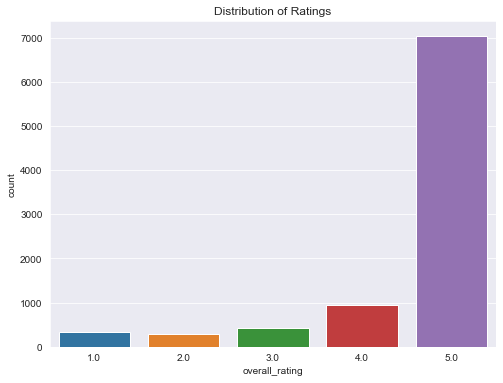

In [95]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Ratings')
sns.countplot(df['overall_rating'])
plt.show()

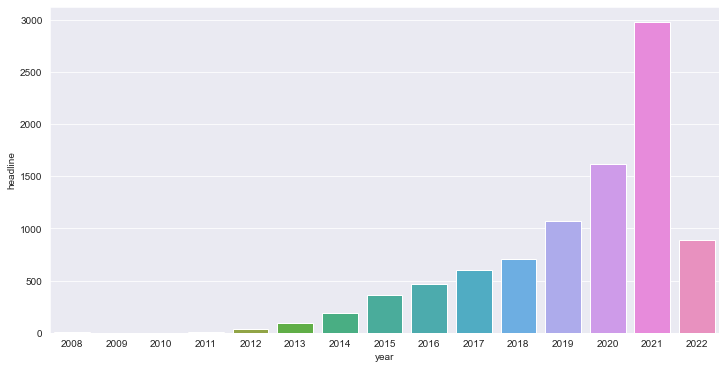

    year  count_normalized
0   2008              0.03
1   2009              0.02
2   2010              0.01
3   2011              0.06
4   2012              0.41
5   2013              1.04
6   2014              2.08
7   2015              4.04
8   2016              5.19
9   2017              6.63
10  2018              7.84
11  2019             11.89
12  2020             17.88
13  2021             32.99
14  2022              9.88


In [173]:
reviews_by_year(top_50_smb_reviews)

In [114]:
tokens = list(itertools.chain(*lst_corpus))
freqdist = FreqDist(tokens)
most_common = freqdist.most_common(50)
most_common

[('work', 5169),
 ('company', 4891),
 ('great', 4433),
 ('people', 3175),
 ('team', 2759),
 ('employee', 2515),
 ('culture', 2375),
 ('opportunity', 1548),
 ('benefit', 1536),
 ('good', 1453),
 ('make', 1292),
 ('working', 1277),
 ('care', 1267),
 ('best', 1256),
 ('environment', 1236),
 ('everyone', 1235),
 ('really', 1210),
 ('leadership', 1207),
 ('product', 1145),
 ('amazing', 1127),
 ('management', 1125),
 ('lot', 1124),
 ('growth', 1087),
 ('get', 1080),
 ('place', 1080),
 ('like', 989),
 ('fun', 983),
 ('job', 974),
 ('feel', 958),
 ('help', 918),
 ('day', 876),
 ('career', 826),
 ('every', 815),
 ('training', 782),
 ('always', 772),
 ('also', 748),
 ('truly', 738),
 ('one', 711),
 ('well', 707),
 ('’', 696),
 ('customer', 687),
 ('office', 677),
 ('year', 668),
 ('want', 667),
 ('hard', 663),
 ('thing', 644),
 ('balance', 639),
 ('grow', 616),
 ('experience', 603),
 ('love', 602)]

In [137]:
# TODO visualize most common words 

In [115]:
total_word_count = len(tokens)
print(f'There are {total_word_count} words in the vocabulary of corpus, after stopwords have been removed.\n')
print('Normalized Frequency\n')
for word in most_common:
    normalized_freq = word[1] / total_word_count
    print(f'{word[0]}: {normalized_freq}')

There are 207730 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

work: 0.02488326192653926
company: 0.023544986280267657
great: 0.021340201222741058
people: 0.015284263226303375
team: 0.01328166369806961
employee: 0.012107062051701728
culture: 0.011433110287392289
opportunity: 0.007451980936792953
benefit: 0.007394213642709286
good: 0.006994656525297261
make: 0.006219611996341405
working: 0.006147402878736822
care: 0.006099263467000433
best: 0.006046310114090406
environment: 0.005950031290617629
everyone: 0.005945217349443989
really: 0.005824868820103018
leadership: 0.005810426996582102
product: 0.005511962643816493
amazing: 0.0054253117026909934
management: 0.005415683820343716
lot: 0.005410869879170077
growth: 0.005232754055745439
get: 0.005199056467529967
place: 0.005199056467529967
like: 0.004760987820728831
fun: 0.004732104173686998
job: 0.004688778703124247
feel: 0.004611755644346026
help: 0.004419197997400472
day: 0.004217012468107639

In [107]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.BigramCollocationFinder.from_words(tokens)
bigrams_scored = finder.score_ngrams(bigram_measures.raw_freq)
bigrams_scored[:10]

[(('place', 'work'), 0.0018065497616169299),
 (('work', 'environment'), 0.0017612728252355532),
 (('feel', 'like'), 0.0015213050624142568),
 (('great', 'benefit'), 0.0015167773687761192),
 (('care', 'employee'), 0.001503194287861706),
 (('company', 'culture'), 0.0013854742532701267),
 (('people', 'work'), 0.001299448074145511),
 (('great', 'company'), 0.001285864993231098),
 (('great', 'people'), 0.0012813372995929603),
 (('great', 'culture'), 0.001190783426830207)]

In [108]:
pmi_finder = nltk.BigramCollocationFinder.from_words(tokens)
pmi_finder.apply_freq_filter(5)
pmi_scored = finder.score_ngrams(bigram_measures.pmi)
pmi_scored[:10]

[(("'change", 'healthcare/life'), 17.752792226369145),
 (("'cons", '.as'), 17.752792226369145),
 (("'fun", 'operative'), 17.752792226369145),
 (("'great", 'sproutdoors'), 17.752792226369145),
 (("'greener", 'pasture'), 17.752792226369145),
 (("'telecom", 'purple'), 17.752792226369145),
 (('.enjoyable', 'problemsolving.ceo'), 17.752792226369145),
 (('.in', 'nutshell'), 17.752792226369145),
 (('12:00pm', '1:00pm'), 17.752792226369145),
 (('16gb', 'ram'), 17.752792226369145)]

In [116]:
"""
min_count (float, optional) – 
Ignore all words and bigrams with total collected count lower than this value.

threshold (float, optional) – 
Represent a score threshold for forming the phrases (higher means fewer phrases). 
A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
Heavily depends on concrete scoring-function, see the scoring parameter.
"""
bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=5)
bigrams_phraser = gensim.models.phrases.Phraser(bigrams_detector)
# lst_bigrams = list(bigrams_detector[tokens])
for phrase in bigrams_detector[tokens]:
    print(phrase)

love working
team
complete
transparency
company
everyone
approachable
people
supportive
flexible
work
hour
great
mentorship
opportunity
supportive
team
even
begin
felt like
part family
first day
onboarding program
without doubt
best ever
seen
also
opportunity
make
immediate
impact
company.there
also
stupid
question
're
quickly
track
become
best version
professionally personally
never
surrounded
intelligence
dedication
inclusiveness
entire
career
idea
always
welcome
regardless position
're
always
celebrating
victory
series
funding
reaching
1,000
employee
international
woman
day
fellow
6senser
birthday.i
also
never worked
company
open
beyond
empowering
disability
even
dedicated
committee
wellness
day
recharge
return
ready
rock
roll.i
'm
humbled
honored
part
fam
great
people
work
employee
opinion
skill
experience
management
extremely
cool
everyone
earth
always
easy
talked
normal
software/
start
environment
fast
growth
expected
grow
even
further.great
benefit perk
unlimited vacation
manage

room
career growth
fun
work
nice
people
amazing
culture
spirit
family
really
make
culture
centric
part
operate
amongst
different department
strong
drive
win
collectively
collaboratively.leadership
transparency
onboarding
highly
streamlined
process
orientedteammates
within
dept
outside
dept
involved
helpfulmany
active
slack channel
stay
date
thing
help
w/inclusivity
virtual
environment
product
market fit
exciting part
fun
solution
sell
company
process
oriented
data
driven
phenomenal
leadership
team6sense
best
product
categoryculture
fun
quality
talent
greattons
momentum
funding
forrester
wave
keep
innovating
hiring
expanding
ceo
know
win
1.
people
genuinely care
whether 're
engineering
finance
operation
etc.
everyone
fully
invested
professionally
well
2.
product
strong
came
company
hearing
great
thing
engineering team
build
company
solution
taking
look
hood
talking
prospect
customer
etc
product
leap
bound
stronger
initial
prehire
assessment
best
people
work
passionate
capable
people
won

'll
stay
neutral
nature
startup
take
review
grain
salt.on
technical
side
would say
platform
quite bit
potential
already
accomplishing
amazing
feat
going
get
stronger
definite
scaling
issue
however
always
going
nature
startup
good
problem
encounter
definitely
solvable
solved
lot
interesting
challenge
work
enormous
datasets.this
brings
next
point
technical
leadership.the
founding
tech
team
smartest people
ever worked
gave
lot
attention
growth
would say
skill
accomplishment
engineer
catalyzed
multiplied
involvement
showed
strong leadership
made
point
grow
trust
people
one
smartest
individual
worked
with.most
founding
team
came
hulu
early
early
day
extremely
experienced
definitely
knowledge
pool
great
work
second
data scientist
eighth
employee
company
almost year
fantastic
leaving
soon
seek
challenge
want
get
experience
record.technicali
opportunity grow
tremendously
data scientist
programmer
data
fun
collaborative
team
process
automated
spend
much
work
directly
dramatically
improves
produ

pacecool
people
work
withemployee
friendly
1.
good
compensation2.niche
technology3.the
senior leadership
especially
founder
earth
personalities4
people
operation
team
best
company
keep
giving
goody
swag
never
ending
thank
pop
hr team
good
take care
employee
well
sending
swag
’
product
stable
yes
disrupting
market.it
cash
rich
startup
work
pressure
higher
side
professional
company
really enjoyed
interview
stage
interviewer
professional
staff
amazing
wait
start
working
company
love working
team
complete
transparency
company
everyone
approachable
people
supportive
flexible
work
hour
strong
product.strong
team.great
people
work
around
work balance
mindblowing.family
value
really
appreciated
here.great
salarygreat
culturegreat
team
response
effort
awesome
culture
employee
suggestion
highly
valued
awesome
appreciation
approachable
leadership
awesome
tech stack
great
learning
good
culture
work
work
culture
great
small company
may
prefer
great place
company
value
correctly
capture
salary
plus


helping
community
professionally
run
company
care employee
well
transparent
operation
recognizes
employee
contribution
life
core value
keep
interest
employee
client
center
interview process
already
positive
culture
firm
believe
great
culture
set
top
senior management
set
good
example
trigger
organization
one
find
following
respect
team spirit
open
mindedness
long
learning
fun
question
stupid
giving back
community
last
least
dog
loving
culture
culture
continuous improvement
empowering
employee
take ownership
project
giving
opportunity
direct impact
worklife balance
priority
actively
recognizing
celebrating
achievement
employee
organization
weekly
basis
everyone
personable
friendly
pleasure
talk
said
would
followed
needed
reached
afterwards
ensure
thing going
ok.
amount
contact
right
1.
really
qualitative
virtual
meeting
received
lot
information
increase
chance
find
job
tesla.2
really
loved
see
wbw
tesla
team
work closely
together
proving
trustworthy
relationship.3
also
every person
pass

work balance
personal
value
line
company
core value
expectation
clearly
laid
employee
rewarded
exceptional
performance.leadership
seems
genuinely care
employees.communication
good
company
priority
shared
tracked.great
work balance
great
team
addressing
need
quickly
friendly
environment
professional
people
lot opportunity
grow
supportive management
great
work
culture
professional
environment
process
oriented
learning development
employee
priority
give back
community
award
appreciation
job
well
done
great
work
culture
transparency
opportunity grow
open door
policy
worklife balance
built
solid
value
give back
community
high
engaging
team
work
one best
company
bay area
way
make feel
home
great
experience
two year
ago
laid
struggling
tough
job
market
took
treated like
family
recruiter
account manager
like
parth
ekta
worked
hard
me.their
management team
strong leadership
founder
amar
president
sonu
ceo
pankaj
clear vision
company
laserlike
focus
executing
member
executive team
like
bryan
vp


keep everyone
well
informed
company
company
continues grow
ensures
internal
career growth
path
individual
company
provides
regular
communication
listen
consider
idea
continually
encouraging
growth
bothe
personally professionally
company
understands
work balance
respect
culture
conducive
creating
friend
mentor
lot opportunity
get involved
based
interest
client
top
name
brand
incredible
thing
impact
way
business
done
’
powerful
place
call
home
everyone
supportive
helpful
team
always ready
help
far best
organization
worked
permanent
work home
good
client
without doubt
one best
staffing
company
work
wanted
work
long
’
relocate
pune
offering
fully remote
opportunity
recruiter
grab
leadership
great
amazing
culture
’
get
paid
work
also
get
respect
care
people
truly
employee
centric
company
many
shared
however
would like
share
major
ones:1
best
incentive
salary
structure
across
industry.2
transparent
environment
absolute
open door
policy.3
fun
work
culture4
timely
appreciation
recognitions5
em

worked
around
1.8
year
interesting
work
supportive
environment
lot
trust
great
work balance
great
working
environment
lot
thing
learn
helpful
team member
healthy
work environment
strong
visionary
knowledgeable
leadership
initial
month
enjoy
know
good
small
size
organization
running
growth
scope
limited
individual
company
genuinely want
help
remain
content
favourism
partial
manager
hurting
progress
good
learning
job
diva
must
heard
learned much
like
sharing
card
1/2
year
indeed
great
journey
founder
past
ceo
laid
solid
foundation
current
ceo
carrying
great
vision
many
staffing
agency
would
..
many
staffing
agency
believe
developing
recruiter
many
company
see future
manager
recruiter
..
record
developing
fine
recruiter
fresh
graduate
resource
recruitment
manager
even
settled
u
–
“
thanks
”
management
belief
hard
work
know
reward
deserving
employee
management
always
provided
constructive feedback
staff
ensuring
organization
operates
smoothly
especially
leader
headed
phenomenal
recruitment

transparent
management
information
might
want
know
shared
even
knew
wanted
know.benefits
great
u
standardssalary
exceptionalworkplace
remotefirst
numerous
resource group
help
integrate
team.hours
flexible.and
course
mission
commendable
great
work
balanceteam
member
carebenefits
statusfriendly
inviting
environment
diversity inclusion
program
great
culture
work environment
care employee
professional development
also
care
personal
life
highly collaborative
crossteam
approach
strong
management team
flexible
understanding
competitive
benefit
compensation
alidade
offer
different
environment
typical
healthcare
setting
since
startup
good
family/life
balance
career advancement
opportunity
super supportive
management
great
interdepartment
support
great benefit
competitive pay
great
work/life balance
company
great
mission
everyone
encountered
strives
make
company
work
great
get
help
keep
people
healthy
hospital
company
make
money
saving
company
organized
structured
remote
working
great
onboarding

company
try
embody
westcoast
startup
culture
public
policy
twist
ambitious
growth
strategy
many
strong
conceptual
thinker
technology
solution
developed
modern
design
functionality
extremely
accomplished
talented
employee
everyone willing
assist
employee
collaborative
problem solving
culture
mission
oriented
accountability
driven
employee
treated
person
cog
machine
although
employee
work hard
work/life balance
emphasized
supportive
family
personal
issue
arise
job
fulfilling
allows
use
past
work
experience
teach
practice
valuebased
care
allowed
use
skill
ability
transform
practice
utilizing
excellent
tool
'm
provided
always
motivated
great
job
due
company
environment
challenge
best
extra mile
extremely
welcoming
staff
exceptional
experience
humility
downtoearth
attitude
casual
environment
high expectation
success
commitment
mission
work
intelligent
teammate
passionate
future
healthcare
flexible
work environment
including
work home
autonomy
best
medical benefit
cost
ever seen
everything
g

virtual
boarding
perfectly
perform
close
approach
manager
great
experience
condition
part
project/idea
international
company
taking care
environment
working
beautiful
product
prevent
food waste
practice
strong
fundamental
regard
client
people
management
company
growth
employee
come first
management
work
towards
strengthening
leadership team
even
heavy
growth
environment
pay
fair
equitable
top
management
aware
employee
reach
stay
connected
even
heavy
virtual
environment
company
decision
typically
based
employee
input
incredibly intelligent
awesome
team member
work
withthey
take
get
employee
onboarded
environment
even
virtually
ensure
employee
understand
whole
organization
friendly
team
straightforward
work
lot
assistance
colleague
great
culture
people
flexibility
work home
really
good
training program
company
expanding
fast
rate
top
50
accounting
firm
fantastic
organization
fantastic
company
culture
truly care
employee
higher level
management
great
job
open door
policy
truly
give
listen

management
great
people
around
really
want see
succeed
company
culture
far best
part
listen employee
implement
change
come
suggestion
environment
show
care employee
communication
great
open
framework
regarding
company
going
everyone
nice
employee
focused
invests
culture
infrastructure
partnership
mentality
leadership
vision
build
bigger
company
dinner
busy season
feel like
genuinely care
employee
ability
actually
work home
firm
care employee
client
number
spreadsheet
leadership
care
everyone
internally externally
propeople
environment
hr
initiative
support staff
provide
leadership
opportunity
full
working home
lot
good
technology
process
surrounding
make
work
efficient
cutting edge
growing
lot
good
people
lot opportunity
learn
access
lot
traning
resource
company
team
focused
discretionary
learning development
resource
big
resources/technology
w/
culture
family
feel
cloud
employee
work home
send
equipment
need.everyone
seems
easy
work
internally
supportive
question
benefit
flexibility
b

reason
people
finest
collection
human
pleasure
belonging
amazing
collection
human
fully
supported
humancentered
framework
beyond
people
get
work
really
amazing
client
helping
maximize
achieve
innovative
elearning
platform
lot opportunity
career growth
company
truly care
diversity inclusion
belonging
reporting
number
incredible
benefit
frequently
expanded
remote work
culture
actually
allows
live
topdown
company
like
want
grow
want
love
job
proved
deep
focus
making
humancentered
decision
aspect
company
work
also
many
career
opportunity
available
today
many
come
see
job
opening
qualify
hesitate
everything
offer
never
look
back
µan
incredible
organization
incredible
people
make
incredible
product
try
saying
fast
three
time
experience
accurate
tonguetwister
representation
like
work
why:1.
talented
collaborative supportive
teammate
people
truly
incredible
'm
thankful
formed
special
lifelong
bond
certain
folx
despite
thousand
mile
apart.2
meaningful
work
get
people
live
life
equip
knowledge
a

product
great
colleague
wonderful
benefit
missiondriven
provide
best
tech
best
customer
support
great
coworkers
management
remote
friendly
decent pay
culture
fantastic
clevels
focused
maintaining
grow.coworkers
fantastic
never
positive
relationship
people
political
maneuvering
slight
worst
game
played.management
present
accessible
flat
structure
mean
drink
personal
conversation
decisionmakers
company.working
home
fantastic
long
're
bit
introverted
commute
take
10
second
never
worry
forgetting
something
home
plenty
energy
left
day
family
friends.truly
flexible
vacation
never
gotten
feedback
management
vacation
except
ask
trip
sharing
story
flexible
actually
flexible
off.articulate
take care
return
take care
basic
titfortat
single
biggest
list
offered
everything
looking
company
successful
strong
work
culture
talented people
fair pay
benefit
flexible
work
schedule/vacation
option
first
company
choose
ambitious
career
strong
worklife balance
imagine
going
back
brickandmortar
ninetofive
job

company
growing quickly
ton opportunity
add
move
career
forward
opendoor policy
customercentric
care
process
employee
appreciation
builtin
flexibility
caring
administration
great
culture
steve
ceo
awesome
great
laptop
screen
employee
trusted
lot opportunity
advancementmanagement
care
well
purpose
vision
culture
people
product
management
care employee
treat u
like
adult
corporate
ski
pass
whole
company
feel like
close
family
employee
centric
cultureclient
focusedability
tailor
working
stylelocation
fantasticgreat
coworkers
practice preach
employee recognition
great
culture
benefit
incredible
strong leadership
clear vision
need successful
good
energy
get
job done
chill
environment
growing company
independence
free snack
breakfast
unlimited pto
work home
needed
good work/life
balance
fun
company
incredible
people
everyone voice
best
ideas/suggestions
implemented
ton opportunity
growth
provides
ability
employee
tackle
big
project
culture
great
product
revolutionary
keep getting
everyday
gr

lot
work
requires
building
creativity
startup
idea
building
scratch
ring
true
want
thing
thoughtfully
high bar
push
really
craft
wo
manship
walk talk
look
people
first
culture
mission
solid
behavioral
team
amazing
company
attracted
great
people
mission
think
company
like
existed
dream come
true
world class
every
measure
onboarding process
truly
amazing
everyone
best
best
extremely
authentic
genuine
practice preach
great
support
system/teamwork
great
people
great
culture
great benefit
workspace
built
support
guide
success
best
company
ever worked
learning
culturehuge
tamproven
product
market
fitmarket
opportunitysales
gtm
team
solid
leadership
well
equipped
willing
helpstaff
around
aligned
missiongreat
benefit
compensation
+1
benefit
+1
emphasis
employee
wellbeing+1
highlevel
learning
potential
thorough
interview process
work balance
busy
day
early
indicator
positive
transparent
organization
company
value
inspiring
leader
giant
vision future
lot
exciting
opportunity
coming
future
someon

clarity
purpose passion
highly
intentional
company
startup
build
fast
sell
fast
hire
fast
...
semimediocre
strategy/plan
really
great
job
thoughtful
early
around
building
right
infrastructure
ahead
startup
curve/track
today
competition
company
growth
constant
bu
seems
want
get
thing
right
start
scaling
quickly
retroactively
fixing/building
thing
startup
miss
early
stage
part
fair
share
startup
'm impressed
work
put
thing
company
care
later
stage
growth
hire
onboarding
huge
investment
manager
training
great
employee
benefit
resources/frameworks
performance review
beyond
people
amazing
...
're surrounded
highly
intelligent
individual
ph.ds
experience
successful
big
tech company
firm
...
importantly
people
kind
highly
empathetic
intrinsically
motivated
mission
inner work
day
allhands
kick
2min
personal
meditation
push
knowledge sharing
beyond
work
place
reading
selfdevelopment
personal
coach
learning stipend
etc
actually
feel like
found
company
interested
produce
execute
one
care
personal

'm
strong
community
colleague
incredible
never worked
mission driven
company
truly
amazing
work environment
incredible
culture
inclusivity
innovation
zero
micromanagement
unlimited vacation
flixible
work
hour
feel like
part family
’
got
high
eq
high
iq
finally
found
company
share
passion
never worked
smarter
dedicated
individual
daily
live
mission
incredibly
kind thoughtful
driven
people
building
outstanding
product
amazing
company
oneofakind
culture
committed
personal development
wellbeing
employee
seems
embody
value
include
playfulness
zest
craftsmanship
super
mission driven
inspiring
work
passionate
smart
interesting
fun
people
low
ego
environment
treated
professionally
respectfully
provided
honest
feedback
interviewing
team
firstrate
organization
culture
creative
healthy
meaningful
work
missionthe
people
work
awesome
communicative
funbetterup
work hard
develop
people
make sure
everyone
feel valued
're surrounded
incredible
smart people
passionate
mission
company
every day
bring who

paid
need
company
mission
great
culture
fastpaced environment
startup
like
culture
strong
systemvery
flexible
work
environmentvision
simplify
reduce
number
uninsured
peopleopportunities
contribute
professional
developmentnative
remote work
environment
purpose
brand
product
solid
widely
understood
common
hear
like
way
solve problem
''
press
u
towards
really
living
brand
team
genuine
supportive
helpful
people
time
tough
time
great
desire
ceo
clear
accountability
path
autonomy
get
job done
culture
product
training
compensation benefit
inclusive
environment
strong
responsibility
reflected
every decision
internal external
company
powerful
company
culture
openness
collaboration
creativity
initiative
encouraged
excellent
leadership
experience
vision
drive
develop
startup
successful
thriving
business
trustworthy
principled
management
healthy
culture
implemented
top
mutual
respect
cooperation
everyone
worked
reasonable
workload
micromangement
senior leadership
every department
populated
smartes

outstanding
professional
work
best class
solution
flexible
work anywhere
policy
inclusive
collaborative
employee
network
transparent leadership
team
employee
opinion matter
taken
heavily
consideration
leadership team
employee
like
working
leadership
work home
flexibilitypassionate
supportive
teamgreat
culture
growing company
innovative
technology
help
customersgreat
compensation
benefitsteam
member
always willing
help
people
best ever
worked
smart
strategic
also
welcoming
collaborative
vision
exciting
working together
bring
make
coming work
day
fun
engaging
company
culture
one best
experienced
career
people
extremely collaborative
energy
level
palpable
motivational
everything
done
purpose
high level
innovation
professionalism
generous benefit
competitive
salaries.amazing
collaborative
culture.nimble
company
adapting
changing
times.amazing
people
committed success
company
care
people
everyone
tied
success
others
creates
great
team
building
great
company
work
treat respect
promotes
advan

great place
work home
friendly
great
culture
telecommuter
friendly
work
pretty much
anywhere
excellent
leadership team
control
destiny
excellent
culture
embrace
work home
collaboration.strong
thoughtful
leadershipvery
bright future
ton
upside
people
want
best
opendoor
culture
enables
employee
collaborate
anyone
company
competitive
benefit
clear
company
objective
announced
leadership team
make decision
aligned
objective
free
continuing education
resource
linkedin
learning
audible
subscription
additional
focused
training
area
expertise
available
fun place
work
great
people
high
technology
innovationlot
visionleading
market
segmentchallenging
stimulatingexcellent
collaboration
companywide
communication
employee
manager
flexibility
phenomenal
culture
excellent
focused
collaboration
purpose
impact
always
supported
virtual
culture
remote
employee
many
year
seen
company
provide
continual
opportunity
career growth
employee
top notch
daily
cross functional
communication
focus
constant
improveme

going
event
seek
talent
u
innovative
thinking
encouraged
executive team
approachable
customer
appreciate
great
people
awesome
culture
around
great place
work
market
leaderdisruptor
work
hometravelcompensation
salary benefit
package
competitive
overall
comp
lot
great
colleague
smart
care
company
bad
appreciated
recognized
management
part
solid
engineering
org
lower level
lot
smart
engineer
engineering
leadership
place
great
vps
overall
strategic direction
muddled
north
bay
make
stick
around
company
bay
know
'd
ever
come
suspect
're
3rd
tier
employee
get
job
zillion
place
sj
stay
short
stop
gap
get
job
employee
talented
ambitiousthere
lot
interesting
thing
learn
grad
great
work environment
ceo
provides
quarterly
meeting
share
company
direction
vision
salary competitive
manger
micromanage
good
set
hardware
tool
great
company
great
people
evolving
company
people
kind
professional
really
talented people
trench
still
get
paycheck.and
hate
say
company
never
really
profitable
currently
losing


available
decent pay
good
thoughtful
competent
employee
excellent
professional
management
nice
paying
packet
training
company
leader
innovation
flexible
hours.great
team.lot
activity
outside
working
hour
team
environment
everyone
invested
growing company
promoting
product
remote
position
lot flexibility
good
atmosphere
professional
happy
zero
company
trust
productivity
high
among
people
get
work
done+
autonomy
enabling
people
best
work
bring
expertise
life+
learn
define
problem
ideal
state
make decision
evaluate/measure/iterate
talent
team
sarah
great
work
excellent
communication
great
transparency
passion
company.all
folk
interviewed
prepared
great
question
clear
idea
looking
role
working
enjoy
every
moment
initial
interview
everyone extremely
nice
attentive
somewhere
back
mind
thinking
would
change
employed
company
make
point
creating
positive
friendly
environment
benefit
overall
success
great
product
smart hardworking
people
flexible
worklife balance
lot
remote
staff
delivering
exce

great
high performing
employee
people
simply
best
bunch
workmate
career
smart creative
fun
committed
team
player
customer love
product
say
wait
tell
world
3.
technology
changing
world
easy talk
product
team
actually
delivering
data
platform
4.
market
opportunity
huge
multiple
billion
spent
space
begun
5.
financials
even
inside
look
outside
watch
world
aside
preipo
different
type
company
term
culture
tech company
culture
highly collaborative
lot
politics
ceo
believe
org
chart
tell
horizontal
place
folk
good
people
want
win
simple
integrity
open communication
respect
seem
highly
valued
people
smart
guy
invented
sql
joined
miss
opportunity
work
company
everyone
try
right thing
management
make
courageous
necessary
decision
opposed
expedient
one
inherent
culture
effective
communication
across
team
expectation
team
without
internal
division
ceo
set
tone
direct
honest
focused
right
goal
become successful
business
creates
amazing
technology
really
change
many
thing
obviously
regular
even
many


positive
lot
high
challenge
people
always
help
without
judgment
freedom
initiative
great
company
culture
inclusive
environment
super
high
tech
product
fast paced
common
achievable
goal
across entire
team
great
company
culture
welcoming
people
super
supportive.interesting
work
dynamic
team
challenge
great
product
wonderful
opportunity grow
lot
thing
learn
friendly
environment
surrounded
excellent
people
benefit
also
great
besides
competitive salary
get
yearly
bonus
monthly
payment
gym
transit
really
good
work
cultureflexible
timing
responsibility
work
projectreally
helped
pandemic
giving
assurance
employee
amazing
cultureamazing
peopleamazing
valuesgreat
manager
super supportive
promotes
growth
speaks
loudest
customer
explicitly
outspoken
association
strategic
operational
commercial
impact
technology
delivers
business
profound
amazing
culture
set
right
top
people
interest heart
genuinely
purpose
highly
experienced
sharpest
capable
ever
come
across
well
organised
business
unarguably
offe

hear
improve.working
network
location
know
matter
city
customer
expect
consistency
employee
feel
respected
valued.i
say enough
company
opportunity
give
employee
reach full
potential
truly
promise
cute
writing
wall
say
meaning
behind
everything
proud
say
work
hope
help
someone
job
hunt
support
team
executive
willing listen
make change
people
helping others
learn grow
people
professional
great benefit
everyone
make
amazing
friend
great
opportunity
think
coworkers
family
truly
enjoyed working
look forward
future
like
pay
rate
12
incentive
program
also
like
hire
make sure
work
outgoing
people
want
like
get
free carwashes
flexible scheduling
disclaimer
best
employer
worked
drawback
job
people
work everyday
greatjob
fun
everyday
differentflexible
schedulesgreat
support
office
fisher
next
topgolfperks
free carwashes
etc
people
great
everyone super
kind
’
always
good benefit
also
always
big plus
’
awesome
opportunity
benefit
tuition reimbursement
401k
incentive
pay
much
fast paced
outdoor
atmo

industry
really
like
people
work
individual
location
corporate office
schedule
pretty
flexible
especially
retail
industry
compensation
par
associate
management
recently
feel
handled
still
handling
covid
pandemic
employee
first
mindset
still
making
stride
keep everyone
employed
without
layoff
flexible
personal
needed
surgery
illness
current
pregnancy.the
benefit
also
helpful
medical
need
well
coworkers
leadership
growth
internally
personal
plenty
benefit
feel like
family
manager
teamworkfun
work environment
rewardingquick
growth opportunity
•great
people
work
picky
hiring
bring best
people
help
keep
morale
high
•management
pay
pretty
decent
•crew
growing quickly
plenty
space
grow•free
washes•managers
get
every
weekend
location
staffing
allows
it•crew
pay
monthly
award
associate
level
team member
incentive
commission
bonus
pay
given
reaching
goal
amazon
gift card
given
everyone
company
promotion based
location
performance
fun
fastpaced
work environment
heavily
relay
teamwork
willingness


’
one best
company
’ ever
privilege
work
work
family
across entire
state
matter
merrillville
bloomington
work
're
apart
family
really
make
shine
pun
intended
also
love
listen
everyone
company
idea
process
project
could
work
always
encouraged
bring
get
conversation
started
tuition assistance
best
retail
industry
even
loan
repayment
program
sign
help
pay
school
loan
faster
always looking
program
help
employee
reach full
potential.opportunity
everywhere
growing
growth
added
many
position
great place
work
looking
career
either
location
support
office.the
leadership
company
second none
always
open idea
work hard
make
best
nicest
people
ever meet
working
blessing
could
prouder
tell
people
work
ask
many
job
’
held
people
make
far
favorite
’
upper management
great
job
truly
listening
people
trying
keep
amazing
environment
best
people
ever worked
with.detailed
comprehensive
training
levels.team
centric
environment
peoplethe
customersthe
atmospherethe
pay
good pay
friendly
team
environment
wonde

patience
time
stepping stone
job
''
career
many
benefit including
biweekly
free wash
work
ultimate
competition
member
cash
prize
’
think
moment
great
training
regular
employee
manager
manager
location
work
proficient
high
accountability
action
keep
management
staff
’
follow
vision
good
thing
know
going
work
every day
working
great
people
training
thorough
easy
know
expectation
plenty room
growth
fast growing
company
higher
ups
listen
u
location
level
input
encouraging
pay
pretty good
benefit
well
fun
friendly
environment
get
work
outdoors
many opportunity
interact
customers.the
team
support
center
always
friendly helpful
even
higher
ups
like
ceo coo
genuinely care
going
people
work
best
company
worked
hired
manager
training
process
detailed
going
expected
starting
interview
multiple
people
make sure
right fit
interview process
mean
worker
live
standard
expect
could
picked
company
continue
journey
management
people
culture
positive
reinforcement
amazing
value
meaningful
lived
everyone
w

day
age
dont
talkthetalk
say
really
walkthewalk
live
dpc
also
truly
value
contractor
compensation benefit
option
provide
testament
happy
work
amazing
company
always
quick
reply
question
provide
competitive
benefit
recruiter
helped
place
exciting
competitive
role
field
intend
keep
long
full
employee
conversion
team
experienced
easy
work
appreciate
close
attention
give
're
helpful
responsive
question
also
simplified
detailed
step
access
payroll
enroll
benefit
know
client
company
well.very
competitive
hr
wages.recruiters
get know
contractor
well
recruiter
regularly
check
make sure
everything
going
well
respect
skill
contractors.random
appreciation
bonus
event
like
birthday
holidays.frequent
communication
contractor
money
flexibility
availability
great
company
work
dpc
great place
work
leadership team
truly care
person
want succeed
professionally
worklife balance
huge
perk
're
able
hybrid
schedule
want
responsive
work
best
rate
great
work
already
truly
apparent
great
company
husband
got
la

effective
support
internal external
customer
emphasis
process
improvement
combined
individual
initiative
keep everyone
engaged
true
collaboration
across
group
benefit
company
whole
grateful
opportunity
work
team
amazing
effectively
communicating
employee
best
meet
career
expectation
reach
periodically
make sure
position
assigned
meet
goal
ensure
necessary
tool
success
care
listen
way
find
job
love
friendly
cool
positive
environment
recruitment
process
benefit
swift
knowledgable
staff
employee
connect
good
following
case
company
mission vision
value
nice
word
throw
website
case
dpc
word
transform
action
employee
operate
make decision
based
mission vision
value
company
leadership
invests employee
technology
culture
education
return
employee
bring
personal
best
work
every day
put
consultant
client
first
grateful
work
people
like
company
could
ever
work
go way
beyond
fact
compensation
superior
agency
free snack
closet
yes
read
right
awesome
party
celebrate
achievement
unbelievable
support


amazing
people
team
people
organization
lucky
experience
feeling
many
time
working
chip
clarke
one
unforgettable
experience
recent
way
mr.
clarke
persuaded
application
spent
hour
convincing
negotiating
making
possible
many
thing
never
considered
important
job
interview
negotiating
table
working
general
chip
clarke
particular
amazing
learning
experience
ended
best
deal
could
think
career
honest
clearminded
knowledgeable
uptodate
respectable
person
know
professional
demand
desire
client
side
table
highly recommend
working
chip
clarke
begin
....
beautiful office
clean
nice
interior
decorating
break room
lot
perk
monitor
desk
like
use
various
program
get
monthly
reimbursement
anything
health/wellness
related
everyone
fun
helpful
good
celebrate success
big
lot
little
contest
reward
pay
equal
staffing
firm
across
industry
training
thorough
get
provide
ideas/feedback
feel appreciated
working
recruiting
hard
around
awesome
people
make
worth
think
working
environment
dpc
recently
helped
land
jo

heard
even
rival
best
company
silicon valley
fully stocked
break room
catered lunch
dinner
daily
expected
pack
pound
unless
're
taking
advantage
free gym
membership
also
care employee
family
generous
maternity/paternity
leave
well
baby
bonus
boot
take
best
best
thats
definitely
reflected
leadership
ongoing training
make sure
best
company
ever
motto
work hard
play
harder
kidding
playing
harder
great
benefitscompany
culture
focused
inclusion
selfimprovementnew
thing
built
implemented
consistentlya
lot
interdepartmental
collaboration
internal promotion
generous benefit
plenty
great
coverage
lot
good
food
eat
proven
platform
differentiated
functionality
quick
roadmap
progress
great benefit
pto
party
food
activity
people
truly
great
loved
worked
smart
kind
motivated
catered lunch
every
daygreat
knowledgable
coworkersamazing
benefitstop
line
equipment
job
thing
hr
department
great benefit
great
pto
gym membership
etc
perk
every
meal
provided
snack drink
frequent
party
family
more.it
casual d

idea
feel like
exciting
working
product
reach
impact
virtually
aspect business
laser
focussed
customer
support
success
postsales
great
role
adequate
technical
cover
client
free
conversation
around
driving
business
product
vision
awesome
completely
believe
wish
could
product
current
job.i
truly
enjoyed working
deep
respect
many
people
trench
worked.there
also
ton
free food
lost
weight
left
worked
really cool
enterprise
tech company
top
hire
really
smart driven
people
pay
well
expect
lot
energy
pretty
awesome
company
culture
something
josh
james
could
concoct
bos
massive
team
sap
oracle
somehow
remains
really
grounded
approachable
addition
wicked
smart
fastpaced
forwardleaning
innovationheavy
environment
benefit competitive
industry
incredibly
generous
utah
company
benefit
amazing
401k
good
also
provide
lot
benefit
like
free lunch
dinner
completely
stocked kitchen
round
benefit package
thing
like
free
free
tablet
maternity
clothing
allowance
throw
best
party
ever
tailgate party
offsite
m

improving
great
lunch dinner
served
daily
many
people
great
work
dedicated
average
pay
position
benefit
top
notch.fellow
employee
fun
intelligent
amazing
free snack
break room
bull
muffin
chip
great
pay
truly
cutting edge
really
take care
employee
great
pay
amazing
product
great
teammate
lot
perk
started working
high energy
amazingly talented
engaged
employee
take
great
care employee
show
great benefit
perk
built
great
culture
maintains
good
work environment
team
made
top
tier
talent
provided
resource
job
well
benefit
great
great
job
making
good
place work
good
product
great
people
work
pay
average
free
foodgreat
atmospherefast
pacedawesome
benefit
strong
culture
engaged
leadership
great benefit
good pay
good work/life
balance
flexible hour
free food
amazing
benefit
fun
working
environment
perfect
work/life balance
competitive salary
list go
good benefit
great
culture
fun
company
lot
growth
continually
change
fun place
work
great benefit
competitive salary
interesting
product
great
ceo

built
proactive
progressive
business
approach
amazing
opportunity
develop
full potential
career
immediately
became
turning
point
’
constantly
held
higher
standard
’
naturally
develop
surrounded
peer
motivate
comfortably
compensated
looked
leader
people
within organization
lead
ethic
character
moral
nature
name
company
well
suited
way
many
ever
list
say
far
part
organization
really
impact
life
people
work
day day
basis
extremely
rewarding.ethos
encourages
u
live
keeping
priority
line
...
faith
family
...
order
know
happy
well
taken care
employee
thrive
work
place
clearly
understands
seen
everybody
absolutely love
working
truly
best
world
culture
company
amazing
although
company
successful
still
focusing
area
growth
working
collectively
company
best
world
part
full
autonomy
schedule
long
work
done
one
micromanaging
also
encouraged
prioritize
value
faith
whatever
coming
first
family
coming
second
work
coming
third
company
commitment
never
wavered
personally
say
anytime
something
came
team

play
similar
role
dealership
none
ever
position
taking
fantastic
company
work
everything
interview process
current
career path
quick
seamless
employee
helpful
informative
industry
training
top notch
prepare
every
opportunity
ahead
company
emphasizes
integrity
professionalism
show
could asked
opportunity
best part
working
organization
never
feel like
make sure
trained
supported
put
position
succeed
always
know
support system
place
help
company
culture
promotes
personal professional
growth
best
career
choice
ever made
truly
best
example
successful
company
best
topdown
leadership
employee
could ask
leader
company
visionary
built
great
thing
probably
main reason
chose
work
great
experience
position
offer
coming
straight
college
limited
work
experience
position
well
rounded
position
opportunity
develop
solid
technique
importantly
develop
leadership
skill
well
addition
vital
handle
administrative
task
experience
gained
working
dealership
partnered
phenomenal
learning curve
good
work ethic
in

great benefit
package
..
great
company
highly
therapist
never felt
supported
appreciated
organization
reasonable
expectation
fulltime
work
great
support
place
weekly
consultation
group
peer
support
option
magnificent
ops
coordinator
handle
scheduling
much
even though
're
remote
right
still feel
much
part team
pay
well
great benefit
transparency
company
value
goal
refreshing
clinicianfriendly
organization
constantly
innovating
improving
experience
client
clinician
excellent
operation
support
handle
scheduling
billing
referral
nonclinical
work
opportunity
grown
improve
clinical
knowledge
open honest
communicationgreat
support
every
rolefulfilling
workcompany
truly care
employee
community
servelots
opportunity growth
lot
support
resource
training
afterwards
lead
open
suggestion
want
everyone
feel supported
company
day
work
collaboratively
amazing
support system
employee
find
company
like
want
stay
grow
everyone
supportive
...
absolutely
room grow
...
absolutely
fair compensation
benefites

ever worked
likely
best place
'll
ever
work
career
month
even
expected
product
way
valuable
call
recording
people
friendly
smart
hard working
earth
impressed
leadership
decision
strategic
business
inclusive
promoting
diversification
come join
u
.you
love
incredible
leadership
truly
value
empath
compassion
product
people
rave
high performing
team
great benefit
awesome
people
wfh
’
fun
building
creates
much
ton
cross functional
collaboration
exposure
area business
experienced
executive leadership
teamit
apparent
great
support
team
operation
designed
rapid
scale
worked
company
size
growing
1/4th
1/2
fast
amount
employee
growing pain
way
worse.great
transparency
heavy
focus
development
level
awesome
development
support
creative
marketingcustomers
love
product
good money
made
really
valuable
place
develop skill
professional
frontlinemanagers
insightful
helpful
broader
organization
care
setting
success
lot
talented people
learn
accomplished
workforce
encountered
yet
high
tech.2
welcoming
sup

true
nope
..
amazing
really
take
invest
people
ensure
positive
onboarding experience
leader
inspiring
compassionate
really
take
know
employee
openly
discus
career
transformation
product
incredibly
strong
continues
get
senior leadership
also
seasoned
massive
market
opportunityincredible
leadership
industry leading
product
huge
opportunity advance
career
amazing
product
great
culture
great
leadership
bright
future.great
work/life balance
great
career
trajectory
clear
path
promotion
smart people
great
product
leadership
fantastic
great
officeamazing
culture
catered lunch
every day
learning stipend
never
leadership
passionate
team
teammate
talented
intelligent
driven
kind
individual
learned much
great
culture
win
team
every
team
brimming
elite
talent
unlike
company
’ ever
worked
competitive
advantage
reason
’
obliterating
competition
despite
coming
market
execution
across
team
level
truly special
creating
top notch
product
customer
experience
company
operationally
mature
age
coo
employee
2

u
super
plus
pm
tech
interesting
feature
see
customer
employee
people
key
principal
company
making
people
raving fan
get
work
great
people
interesting
innovative
environment
encouraged
grow learn
every day
clear
company
direction
great
leadership
execution
customer
raving fan
wonderful
talented
team
great place
learn
develop
product
keep getting
happy
part
company
working
smart talented
people
leadership team
inspired
much
importantly
leadership
actually
listen
genuinely care
colleague
super smart
modest
friendly
management
experienced
transparent
space
operates
exploding
’
fantastic
ride
part
people
culture
great place
grow
great
people
professional
lead
impressive
people
amit
eilon
interesting challenging
work
staff
care
worker
great
location
challenging
talented people
great
atmosphere
company
care
lot
employee satisfaction
interest
cherish
company
value
believe
product
business
management
amazing
vision
business
leadershipthe
il
team
great
helpful
people
ego
supportive management
t

team member
culture
everyone treated
exactly
way
people
working
thoughtful
considerate
intelligent
adaptable
're
building
product
reach
million people
every day
take seriously
responsibility
ethically
high
premium
placed
user
respect
genuine
company
care employee
life
wellbeing
incredible
company
great
product
strong leadership
focused
driven
yet
humble
inclusive
technology
extremely
userfriendly
ai
actually
work
addressable
market
massive
tremendous
opportunity growth
amazing
team
culture
mission/valuesdriven
work
highimpact
project
drive
seeable
company
perfect place
work
want
make impact
able
work
intelligent
genuine
humble
colleague
every single
day
product
positively
impact
ten
million people
every single
day
company
care
individual
growth
budget
set
aside
learning development
thoughtful
engaged
leadership
amazing
office
free catered
lunch
daily/snacks
grown
last
7+
year
3x
next
longest
tenure
huge
testament
culture
focus
growing
folk
within
intellectually
stimulating
inspiring
ch

benefit
like
sport
compensation
medical
also
receive
opportunity grow
develop
company
really
interested
making
best
specialist
sphere
invests
lot
money
development
always
aggressive
achievable
goal
whole
atmosphere
company
prompt
perform
people
hired
value
talent
make
big
difference
great place
work
great
people
great
product
rare
company
ukraine
culture
value
exist
formality
fact
everyone
join
company
share
eager value
understands
importance
may
expect
trust respect
support
colleague
whatever
happens.2
'll
work
professional
never
stop
learning
committed
result
'll
challenged
'll
gain
much
experience
sure.3
people
used
work together
also
fun
together
frequent
teambuildings
masterclasses
talent
show
etc
humancentric
company
develop
potential
highest
realize
challenging
idea
unique
engaging
event
stay
memory
heart
grammarlians
people
whose
value
meet
value
company
work
talented
colleague
great
product
healthy
corporate culture
many opportunity
professional development
dedication
culture


good benefit
never worked
open honest
business
're
transparent
goal
process
care employee
opinion
quality
amount
growth
insane
best
way
employee
encouraged
speak
truth
change
implemented
make
open communication
great place
learn grow
team
full
talented passionate
people
everyone
work together
reach goal
culture
best
’
experienced
company
great
culture
great
people
lot opportunity
culture
great
topknotch
everyone
incredibly
collaborative
willing help
others
leadership
care employee
make sure
every
voice heard
high level
transparency
leadership team
rest
company
everyone
know
company
goal
clear
path
get
innovative
interesting
importantly
work
influencer marketing
great
industry
love
client
company
structure
culture
direction
productivity
goal
transparent
employee
nicest
everyone
one
goal
hustle
hard
make sure
goal
achieved
want
fastmoving
industry
love
busy
work environment
apply
cool
part
company
fast track
growth
disrupter
industry
fully remote
gogetter
super
organized
looking
grow
hom

daily basis
highly recommend
anyone
want
wake
every morning
excited come
work
make
stuff
happen
oh
mention
awesome
office
fully stocked
redbull
fridge
yup
experienced
leadershipculture
accountability
level
driven
data
great
benefitsautonomous
still
supportive
remote
first
policy
even
postcovid
employee
entrepreneurial
mindsetgreat
product
’
month
far best
company
’
worked
for—
ever
really appreciate
selective
come
management
company
director
mean
handful
leader
company
great
job
planning
future
company
pay
attention
helping
foster
employee
growth
along way
offer
much
come
personal professional
development
employee
seek
everyone
really
open idea
anyone
’
lot freedom
job
also
growing
area
outside
direct
expertise
also
love
everyone
across department
really
encourages
support
’
together
company
fantastic
say
leadership
really
trying
right thing
company
customer
employee
career
worked
many
team
humility
team
exhibit
breath fresh
air.from
company
fundamental
perspective
profitable
growing
s

opportunity
family/life
balance
work hard
significant
push
make sure
employee
maintaining
work balance
push
ensure
take
provide
flexibility schedule
necessary
take care
personal
thing
choosing
changed
forever
thankful
also
chose
people
number
willing
employee
assisting
personal/professional
growth
working
company
established
mission/vision/values
live
values.getting
dip
toe
department
interested
learning
expanding
knowledge
future
growth
looking forward
coming work
feeling
like
place
belong
dedication
team
members/coworkers
project.having
company
meetings/lunch/celebrations
allow
employee
get
together
socialize
celebrate
accomplishment
one
may
usually
come contact
people
everyone
working together
one
common goal
everyone
truly
back
within company
care
person
company
love coming
work everyday
teammate
surround
banilla
game
culture
based
company
provides
positive
environment
people
work
love coming
work everyday
living
mission vision
value
well
growing
professionally personally
people
ma

401k
enrollment
period
per year
expedite
enrollment
process
team member
part team
team
expects
excellence
one
consistently
trying
get
whether
improving
culture
developing
company
mission statement
trying
achieve
certain
goal
always trying
improve
individually
team
want
part
dynamic
competitive
team
unlimited
growth potential
lot
working
upper
level
management
great
work
lot
work
understand
employee
level
manager
take
leadership
course
develop
leadership
management
skill
company
nearly
year
received
one
pay
raise
potential
promotion
relocate
state
office
employee
easy
work
since
strive
live
company
mission vision
core value
least
week
heard
conversation
regarding
way
give back
employee
whether
bonus
increased
healthcare
contribution
additional
companyprovided
meal
owner
company
genuinely care
employee
product
attitude
reflected
executive
staff
way
average
employee
everyone
invested
product
create
...
way
product
lifecycle
worked
two year
learned lot
left
career
goal
align
company
fault


work/life balance
ability
generate
revenue
client
constantly
celebrating
success
milestone
taken
pandemic
seriously
allowing
people
remain
remote
schedule
plan
affordable
yet
coverage
plan
since
graduated
college
specifically
advocacy
involvement
leadership
continues
consistently
solicits
input
entire organization
grow
team member
driven
talentedleadership
compassionate
personableinteresting
varied
projectsyour
effort
valued
rewardedno
pressure
conceal
play
identity
people
get
work
smart creative
around
goodhearted
people
everyday
work
work
allstar
client
help
bring idea
reality
're
creating
'll
love
benefit
pay benefit
onpar
industry
...
complaint
people
culture
everyone
work
amazing
learn much
also
ton
fun
fast growing
company
allows
really
contribute
growth
meaningful
way
great
company
culture
high performing
fun
provides
ability
work
really
challenging
cutting edge
project
strong leadership
team
continuous learning
environment
interesting
projectsincredibly
smart hardworking
people

box
thinking
collaborative
exciting
feeling
part
incredible
company
incredible
product
easy use
customer
die
hard
fan
friendly
environment
nurturing
growth
amazing
place work
grow
company
breath fresh
air
incredible
level transparency
leadership
care
people
product
amazing
would recommend
everyone
work
best place
ever worked
truly
amazing
review
amazing
culture
learning
contributes
healthy
approach
career development
great
product
great
team
highly collaborative
friendly
churn
burn
culture
great
management
great
product
consistently
exceed
quota
mission
people
ability
impact
cool
project
employee
highly
valued
taken care
of.growth
learning opportunity
available
encouragedcompany
culture
inclusive
supportivefilled
smart motivated
professional
across
organizationstart
feel
stability
resource
large
company
great
work environment
brilliant
coworkers
huge
culture
learning
focused
employee
development
great place
curious
driven
need
comfortable
uncomfortable
people
unique
blend
super smart
h

investing
building
leadership
skill
best version
etc
charge
success
micromanaging
leadership
mean
working
kb
easy
business
constantly evolving
must
easily
adapt
change
work hard
thrive
role
rewarded
note
might
considered
everyone
fact
need
handholding
kb
probably
right
company
flexible
work environment
hour
ability
wfh
office
awesome perk
friday
lunch
happy hour
game room
wellness
reimbursement
paid holiday
company
outings/celebrations
unlimited pto
name
regular
check
ongoing
feedback
lot
company
360
feedback
culture
actually
walk walk
kb
walk walk
company
connection
office
across
u
many
employee
working home
sometimes
difficult
connect
peer
meaningful
way
kb
host
biweekly
donut
date
connect
someone
company
15+
minute
fun
chat
outing
community
give back
opportunity
kb
recognizes
important
give back
community
kb
provides
opportunity
staff
participate
local
food
hygiene
clothes
toy
drive
organization
like
toy
tot
local
shelter
✅
ever
wondered
like
jump
rocket
soar
moon
working
matter rol

never felt
welcomed
right
bat
positivity
really
contagious
here.leadership
open door
policy
company
survey
town hall
address
question
ceo
transparent
company
worked
past
everyone
opportunity
speak
contribute.company
growing quickly
plenty opportunity
growth
continuous
training
google/bing/fb
etc
company
culture
creative freedom
fun
benefit
ample
learning opportunity
worldclass
onboarding
training
fun
collaborative
team
environment
great benefit
awesome
ceo
wonderful
team
fun
collaborative environment
competitive pay
great benefit
ton opportunity
grow
well
great
people
work
want
willing
work
able
actually
grow career
rather
dream
working
great
one
thing
set apart
agency
amount
work
're willing
put
correlate
're
want
addition
work hard
play hard
oriented
need
lot
handholding
rigid
structure
may
best place
due
fastchanging
nature
industry
get done
mentality
prevalent
get done
key
guidance
point
perfect place
also offer
great
amount
flexibility
want
excel
within company
even
want
try
somet

hire
experienced
talented individual
work hard
fun
work
definitely
team
mentality
understanding
certain
team
product
area
well
benefit
entire
company
mean
people
always willing
able
chip
across
multiple
area
company
much
cando
get stuff
done
culture
well
thoughtout
manner
always
focused
broader
direction
strategy
company
leadership
fantastic
model
type
culture
wish
maintain
everyone voice
best
idea
shared
implemented
flexible
working
culture
nice
especially
people
family
commitment
everyone
work
extremely
hard
make sure
letting
team
wonderful
company
part
culture
healthy
positive
happy
provide
excellent benefit
safe
respectful
work
place
ethic
everyone
nice
friendly
everyone
working
truly
passionate
job
natural
enthusiasm
come
help
always
around
corner
people
check
make sure
're
ok
need
helping hand
anything
hard
fast
rule
harsh
demand
management
rather
entrusted
role
task
timemanagement
're
keeper
responsibility
discipline
getting
work
done
highest level
timely
fashion
like
respected


live
healthiest
life
•
precision
cloud
phc
platform
transforming
healthcare
research
genomic
discovery
delivery
program
precision
future
individual
wellness
selfcare
leveraging
full
spectrum
diagnostic
engagement
tool
including
multichannel
medium
mobile
apps
linked
ultrasecure
cloud
analytics
capability
•data
integration
tool
precision
cloud
phc
designed
integrate
data
type
including
genomic
lab
result
image
patientgenerated
data
among
others
help
researcher
accelerate
discovery
clinician
efficiently
diagnose
identify
personalized
treatment
recruit
patient
clinical
trial
•full
mobile
integration
’
mobile
application
including
fasting
tracker
extend
well
customized
solution
industry
partner
•from
ceo
brown
throughout
company
culture
creativity
focus
getting thing
done
enjoy
highly
competent
team
positive attitude
collaborative
spirit
high
mark
leadership
education
help
understand
mission
fitness
freedom
grow
job
working remotely
standard
weekly
allhands
meeting
always
know
happening
en

industry
brought
number
best
people
along
adventure
'm grateful
excited part
startup
feel
feel like
contribution
make difference
product
work
actually
improve
people
life
transparency
frequent
meeting
discus
company
going
value
work
learned lot
since
coming
nice
equipment
macbooks
5k
monitor
standing desk
super talented
dynamic
team
flat
organization
structure
endless
learning opportunity
outside
area
opportunity
constantly
challenge
thing
differently
brings
company
user
need
positive
open minded
adaptive
attitude
everyone voice
heard
fast pace
never dull
moment
well funded
growing company
strong
belief
getting thing
done
high quality
excellent
product
management
research
focused
make
right
decision
highly
capable
leadership team
member
really
exciting
future
lot opportunity
grow
surrounded
intelligent
staff
good
people
everyone
complete
goal
plenty
freedom
long
complete
work
love
teamwork ego
starting
top
everyone voice
heard
contributes
building
tool
really
help
change
healthcare
pos

people
eager help
coworkers
collaborative
work environment
review
process
intensive
meant
pick
right
people
really
enjoyable
interviewer
everyone
nice
made
interview
conversational
yet
topicfocused
care
community
giving back
giving back
day
donation
good
location
downtowngood
snack
kitchen
great
atmosphere
coworkers
intense
training
sdr
begin
plus
flexibility
culture
pto
product roadmap
came
big
corporate
found
working
much
smaller
company
truly
refreshing
put
forward
idea
expect
heard
given
creative freedom
think
solve problem
empowered
organization
solve
them.if
talent
drive
selflearner
thrive
put
many
situation
one
solving
given
task
may
many
people
lean
finding
solution
sink
swim
situation
confident
ability
that.but
able
well
situation
recognized rewarded
dream come
true
nice
people
within organization
product
interesting
technical
manager
treat respect
micromanage
relaxed
deadline
understanding
upper management
great
workplace
highly recommend
great
culturenice
career
support
adva

making
mark
company
really
good
company
culture
successful
workplace
company
culture
apparent
day one
workplace
environment
people
obviously
enjoy
part
benefit
great
modern
decor
open
floor
plan
drink
snack
provided
amazing
staff
hire
everybody
going
way
make sure
everything need
track
success
crazy
smart people
collaborative
fun
culture
training
career development
addressed
straight
gate
remote
opportunity
available
free snack
lot
structure
support
employee
clear
goal
process
forward thinking
company
positioned
disrupt
market
benefit package
benefit package
one best
clear
company
care
need
employee
unlimited pto
1k
bonus
completely
unplugging
work
week
stellar
team
brightest
people
privilege
working
everyone
work hard
also
like
fun
office
felt comfortable
talking
employee
level organization
growth
experiencing
extreme
growth
predicted
continue
trajectory
exciting part
organization
experiencing
great
success
move
incredibly
quickly
never dull
moment
company
culture
always
event
put
lot

state
vast
majority
people
smart motivated
enjoyable
work
company
growing
steady
rate
continues
prove
one best
product
space
company
center
around
truly
awesome
saas
project
people
love
passion
contagious
plenty
smart people
impressive
work
great
balance
fun/startup
culture
seniority
maturity
leadership
level
perk
compensation
topnotch
promoting within
common
employee
feel empowered
anything
possible
great
people
product
address
market
perfectly
team
allow
autonomy
creativity
one favorite
part
working
great
company
culture
team
genuinely
like
coming work
collaborating
another
bonus
leadership team
recognize
people
strength
help
create
job
maximize
potential
great
productgreat
work environment
employeesgreat
benefitsgreat
engagement
management
lot
learning
lot
hard
challenge
surrounded smart
motivated
people
everyone
eager help
ask
recognition
good
work
nice office
great
ocean
view
food snack
ping pong
foosball
beer
healthy
lifestyle
part
culture
amazing
place work
driven
person
ton roo

like
culture
good salary
structure
standardgood
leave policy
additional
benefit
like
harmony
bonus
good
bonuswork
balance
friday
gift
occasionally
good
company
lot opportunity
good
management
hr team
benefit
flexible
work
perk benefit
growth
professional development
company
really care
employee
work
culture
amazing
every
would
get
goody
reward
appreciation
job
well
pretty
happy
working
one
surely
find
work balance
nice office
good
snack
great
barista
feeling
getting
fired
relieving
great
worklife
balance.great
team.great
award
work
culture
benefit
good
learning curve
gift
vouchers.friday
month
great
lot opportunity
learn
people
brilliant
lot
benefit
lm
company
think
lot
employee
growth
market
fast
industry
good
company
work
great
product
great
culture
company
going
place
opportunity learn
technology
nice
onboarding
package
driven
efficient
amazing
welcoming
people
great
office space
continuous
training
great
incentive
technology
stackwork
cultureemployee
benefits.you
may
find
good
tech

ethic
across
business
everyone
keen
help
one
another.fantastic
career progression
meritocracy
show
rewarded.superb
benefit
team
event
starter
pack
unplugged
etc
etc
etcall
underpinned
wonderful
product
incredible
engineering team
strong
team
culture
competitive
working
environment
ambitious
growth
plan
great place
hone skill
salesperson
technician
customer success
rep.
structured
focused
procedure
embodies
fast paced
high
tech
business
growing rapidly
chance
involved
shaping
culture
success
business
master
career
paththe
staff
encourage
employee
succeed
demonstrated
investment
training
121
senior management
career
general
well
focused
goal
setting
opportunity
offered
going
hyper growth
got
feel
company
two
people
interviewing
knowledgable
productit
relaxing
atmospher
vibrant
proactive
team
drive
great
team
culture
exposed
variety
different
opportunity
individual
development
company
culture
greatlets
perksbest
team
worked
withplenty
option
progress
find
right
niche
team
team spirit
comp

company
loved
executive leadership
peer
build
u
enable
u
best
work
great
environment
teamroom
growth
leader
team member
growingbutstillfeelssmall
feel
great
tech
stacklots
opportunity
advancementcool
problem
work
onother
engineer
really
helpful
solving problem
engaged
management
amazing
company
culture
autonomy
knowledge
experience
many
thing
loved
changed
last year
many
great
employee
left
originally
loved working
—
people
knew
cared
core value
like
innovation
teamwork ego
—
manager
trusted
gave
space
produce
best
work
without
micromanaging
putting
—
trusted
executive team
make
best decision
business
employee
—
historically
hired
many
best brightest
valley
robust
neurodiverse
culture
worked
many
incredible
people
team
—
snack
abundant
lunch
monday friday
coworkers
typically
awesome
good
job
hiring
good
people
floor
lot
le
typical
salesperson
compared
similar
orgs
executive team
great
decent
level transparency
within company
benefit
great
beyond
help
aspect
weekly
lunches/stocked
break

ceo
scum
bucket
like
many
startup
brilliant
bar
hiring
employee
extremely
high
every
employee
intelligent
hardworking
contributes
company
already
profitable
stock
immediately
valuable
lot
free food
free
public
transportation
coworkers
senior management
probably
talented
're going
find
utah
many
job
lose
shine
612
month
company
really
hire best
take
retain
good
people
lot
fun
hardwork
within
limit
clear communication
expected
pay
competitivepromotions
quick
beyondamazing
learning opportunity
smart
peoplemanagement
genuinely care
career growth
employee
company
great
culture
great
people
people
make sure
positive
experience
care
collaboration
teamwork
present
overall
fun
environment
work
•management
awesome
•great
opportunity growth
promotion•provide
great
pay
benefits•night
day
tech company
area
regard
personal growth
job
satisfaction•transparent
company
figure
projection
management team
superb
take
sincere
interest
development
well
employee
company
clear vision
executing
relentlessly
vi

every level
great
mission
great
people
small
team
size
value
missiondriven
company
care employee
client
customer
flexible schedule
fully remote
competitive pay
generous benefit
ton
support
resource available
1:1
supervisor
consultation
group
clinical
consultation
detailed
help
center
resource
communicative
responsive
transparent
great
listening
incorporating
feedback
management
intentionally
work
create
space
community
inclusion
consistent
flow
great
client
fun
work
keep
full
caseload
system
integration
impressive
userfriendly
free
continuing education
opportunity
friendly
community
people
eager
part team
wonderful
coworkers
management
principle
action
remote/hybrid
work
smart
colleague
collaborative environment
challenging problem
fun/unique
perk
commitment
deib
huge
passionate
behavioral
right
place
truly
walk talk
thing
wellbeing
provide
best
benefit
resource
support
everyone
role
culture
amazing
care deeply
work/life balance
organization
continues
impress
culture
open
dynamic
great

mission
flexibility
support
pay benefit
mission
everything
staff
benefit
flexibility
salary
bonus
work home
flexible schedule
cohort
consistency
great
work
flexibility schedule
flexible
work
schedule
work environment
opportunity
flexible schedule
compensation
clinical
work
free
strong
vision
lot
innovation
happening
empathetic
smart people
rate
pay
good
working
mission driven
company
deeply
committed
providing
high quality
care
commitment
high quality
clinical
care
come
right
top
surrounded
amazing
colleague
positive
feedback
happy
client
customer
provider
every day
great
worklife balance
particularly
parent
dog office
easy use
online
system
support
therapist
excellent
ceo
smart
care employee
missiongreat
downtown
burlingame
locationcollaborative
coworkersgreat
customer
remote work
home
part
schedule
say
lot room
growth
within company
management
diligent
helping
move
great
holiday/pto
client
high
demand
therapy
client
motivated
engaged
treatment
also
mix
different
client
variety
nice
p

start
comparison
typical
corporate culture
refreshing
part
motivating
supportive
culture
feel like
speak
freely
input
regardless
level
valued.2
leadership
vision
company
kink
company
leadership
hold
themself
accountable
focus
improve
business
blaming
people
company
goal
challenging
realistic
'm excited
see
grow/progress
working
three
month
geographically
remote
company
transitioning
away
start
culture
recent
ipo
summer
2021.
plenty opportunity
make
mark
establishing
process
helping
steer
company
handle
exponential
growth
fintech
industry
worldwide
great
onboarding process
give
hire
creative freedom
impact
company
growth
particular
expertise
experience
get
build
something
multicultural
organization
working
people
many
background
country
region
around world
company
expanding
market
globally
tool
provided
encourage
collaboration
productivity
collaboration
area
strong
eliminating
traditional
siloed
environment
company
grow
past
start
stage
healthcare
premium
fully
paid
pet
compensation pac

succeed
within
role
high
growth
customer
retention
great
team
great
talent
friendly
environment
conscientious
progressive
upper management
stripe
adyen
braintree
done
much
disrupt
acquiring
side
payment
still
largely
first
disrupt
issuing
side
year
ahead
stripe
proof
point
contract
uber
square
instacart
affirm
doordash
jp
morgan
...
many
company
market
cap
much larger
marqeta.company
recognizes
need
mature
company
senior leadership
get
u
next
stage
chief
product
officer
coming
daddy
chief
people
officer
pixar
chief
officer
intuit
chief
marketing
officer
mulesoftgood
culture
including
free food
around
office
transparency
senior
exec
without
snobbishness/elitism
sf
tech
companiesone
company
done
pandemic
raised
150m
full
incredibly smart
talented people
fun
culture
match
great benefit
competitive salary
smart people
high
growth
startup
really
caring
leadership
amazing
business model
great
perk benefit
love
building
place
2020
already
remarkable
year
company
despite
many
unexpected
challe

company
core value
value
feel
integral
finding
fulfillment
even
company
practice
preaches
outcome
incredible
looking
place
like
long
'm excited
share
vision
crazy
smart
coworkers
great
engineering
culture
foundation
trust
incredible
overall
company
culture
culture
awesome
generous pto
onboarding process
really
nice
organized
really
want
make sure
employee
comfortable
need
organized
get
thing done
prefer
solid
product
fantastic
team
amazing
history
culture
provides
every
benefit
could
possibly
need
get
work
done
stress
free
environment
challenging
interesting
work
great benefit
company
shown
multiple
time
care employee
make
good
place
everyone
worked
far
great
flexibility
role
great
work environment
benefit
decent
place
decent
people
complete
comprehensive
onboarding
training
ever experienced
career
wonder
win
award
training
excellence
company
truly
life
stated
value
want
part something
positive impact
humankind
look
onboarding
feel
overwhelming
working
though
added
much
personal
touch


making
big
difference
company
perfect
formula
want
career
appreciate
company
great
fit
everyone
team member
come
diverse
background
accepted
appreciated
team member
founder
mindset
drive
provide
right
level
last
good
work balance
startup
culture
founder
benefit
culture
people
building
management
excellent
people
excellent
product
great benefit
strong
trajectory
hiring process
allows
network
several
leader
within
company.lots
benefit
trust employee
unlimited
pto.competitive
casual
work environment
perspective
culture
benefit
management
philosophy
perk
love
people
work
love
people
work
love
overall
purpose
company
world
financially
strong
live
say
culture
istons
foodreally
cool
workersawesome
leadership
meaningful
workother
benefit
strong
engineering
culture
feel empowered
get know
need
get done
helpful
coworkers
surrounded
expert
love
learn
high
code
standard
building
meant
last
decade
work
today
opportunity grow
freedom
work
area
interest
bring
mission
company
great
helping
world
becom

thing
really
impressed
month
town hall
executive
board
answer
employee
question
level transparency
also
great
sign
colleague
announced
looking
position
leadership
honestly
helped
finding
something
awesome
many
place
worked
fired
someone
made
mistake
mentioned
job
searching
found
refreshing
another
thing
really appreciate
level
professionalism
colleague
interesting
dynamic
ceo
riding
around
scooter
nerf
battle
wage
yet
honestly say
single person
entire
company
negative
feeling
towards
zero
drama
also
really appreciate
flexibility
basically
company
expects
get
work
done
well
heard
anyone
issue
work balance
people
work remotely
people
come
ungodly
early
leave
early
people
work
day
week
stay
etc
also
people
bring
family
pet
community
feeling
benefit
catered
breakfast
monday
wednesday
catered lunch
tuesday
thursday
stay
past
6pm
free catered
dinner
well
awesome
fancy
espresso
machine
also
amazing
snack
also
ship
laundry
gym
crash
pad
game room
people
operation
sincerely
try
make
best place


mission
part
feel like
're
really
working
company
chance
make
big
difference
passionate
team
strong
mission
phenomenal
product
awesome
culture
hyper growth
open communication
highly
regarded
fintech
industry
employee
valued
empowered
great
leadership
engineering
loosely
structured
allows
employee
grow
micromanaged
everyone
friendly helpful
attitude
overall
positive
free snack
opportunity
work
talented
intelligent people
well
positioned
market
open
vacation policy
open
vacation policy
upbeat
atmosphere
cuttingedge
everything
employee
generally
talented
great
team
really
like family
awesome
benefit
great
team
company
culture
great
free lunch
twice week
fun
challenge
solve
rewarding
job
meaningful
product
fast growing
company
amazing
people
great
leadership
awesome
team
industryleading
product
strong
vision
capable
management
great
culture
intelligent
bright
individual
although
honest
talented
hard working
employee
fleeing
rapidly
great
looking
user
interface
high
salary
flexible hour
unl

amazing
manager
team
matesstrong
focus
collaboration
professional growth
inclusive
culturefast
straightforward
interview onboarding
process
'll
always
busy
lot
different
type
project
learn
remote work
want
great place
work
lot opportunity
grow
great
culture
positioned
growth
constant
learning
within
rapidly growing
company
learning opportunity
culture
direct
line
executive team
recognition
great
company
supportive
environment
ton opportunity
grow
skill
career
wise
little
busy
time
practice
would recommend
flexible
workplace
autonomy
take
project
lot
growth
role
different area
business
enjoy
startup
environment
great
company
work
worked
large
firm
multiple
year
spent
majority
one
enterprise
project
since joining
back
september
apart
different
project
much
exposure
many opportunity
grow learn
every week
different
keep
work
exciting
enjoyable
community
cohesive
structure
top bottom
shared
goal
responsibility
rapid
growth
personal development
perspective
organizational
respect
instantly
we

talented
technology
operation
side
excellent
culture
senior management
culture
inclusivitytransparency
company
operation
position
leadership
decisionsextremely
forward thinking
desire
question
status
quo
effort
improve
innovateleadership
coworkers
actually care
one another
small
yet
growing
firm
innovative
hard worker
take pride
expert
desire grow
caring
committed
employer
great
work
place
inspirational
truly
best talent
tech industry
brought
together
one
roof
recent
producer
hire
incredible
expert
craft
year
tough
whole
country
newfrontstrong
’
excited
keep
building
making
progress
every day
strong
supportive
executive
backing
producer
account manager
csas
engineer
employee
company
collaborative
culture
everyone voice
truly
matter
easily
speak
coo
ceo
anything
need
brokerage
find
strong
backing
management
heavy
level
expertise
industry
nice
people
supportive
bos
previously
’
everything
insured
word
outlook
’
bringing
twenty
first
century
talent
agency
incredible
many
genius
really
bui

encourage
question
leadership
effort
nice
blend
corporate
organization
startup
vibe
pay
great
purpose
mission driven
company
one
say
sake
sounding
modern
company
fostered
environment
enabling
employee
work
coordination
toward
collective
vision
impactful
vision
started
role
wfh
another
company
due
covid
bit
unsure
starting
journey
fully remote
company
however
experience far
exceeded expectation
every
teammate
genuine
kind
collaboration
productivity
team
exceeded expectation
including
great
virtual
team
event
even
comparison
past
inperson
company
worked
employee
ample
space
ownership
ability
make
meaningful impact
working
easily best
career
move
made
thus far
great
culture
everyone
work
team
remote work
offer
flexibility
high level
transparency
business
decision made
opportunity
work
category
defining
company
despite
fastpaced
startup
based
sf
everyone
kind
caring
–
tech
bros
everyone
say
table
easy
access
executive
exec team
transparent.awesome
benefit
great
communication
leadership
vis

even
mission
enrich
life
making
second
home ownership
possible
enjoyable
people
mission
motivates
team
foster
collaborative
workforce
team
smart
innovative
best
leader
tech
estate
first
experience
working
purposefully
distributed
company
nothing
positive
thing say
leadership
extremely
communicative
positive
nimble/agile
trust employee
business
function
fastpaced
startup
culture
every day
different
love
huge focus
employee engagement
communication
wellbeingexcellent
benefit
salarysolid
worklife balance
boundariesaccessible
honest
leadershipextremely
talented
impressive
leader
staffexciting
growth
ability
learn
daily
people
pretty
awesome
ton
intelligent
talented
caring
individual
working together
much
leadership
experience
understanding
come first
work
mean
end
never
issue
getting
illness
emergency
etc
offer
unlimited pto
mean
within
reason
ask
every
monday friday
worked
company
several year
seen
grow
startup
much larger
industry
player
aside
growing pain
done
admirably
able
adapt
quick

incredible
people
regional manager
hr
genuinely care
work
empathy
make sure
feel
supported.new
structure
team
way
really
help
alleviate
pressure
csas/cscs
roles.fully
paid
premium
pet
unlimited pto
manager
actually
understand
importance
occasional
day
fun event
great
holiday party
team
bonding
event
monthly
newbie
feel included
right away
fun
environment
beer kombucha
tap
snack
scooter
ping pong
super
bros
club
hipster
vibe
pretty much
every
millennial
dream
work environment
anyone
management
leadership
position
great
unlimited pto
culture
nonpolitical
nature
executive
management
friendly atmosphere
ability
get
thing done
low/no
bureaucracy
budget
buy
tools/technology
invest
people
fast pace
opportunity
advance/grow
great
culture
amazing
people
lot opportunity
recently
gave
share
employee
year
mark
team
run
fast
seems
really care
employee
take
month
give
prop
different department
opportunity move
quickly
get promoted
great
people
truly
brilliant
mind
unlimited pto
nice
mention
people
g

day
turn
team
work hard
everyone
weekly
1:1
leader
provides
opportunity
discus
area
opportunity
improvement
advancement
senior leadership
constantly
communicating
goal
feedback
future
plan
team
team member
treated like
human
leadership
encouraging
making
possible
focus
well
outside work
day
working
always
glaringly
obvious
company
priority
order
company
show
excellent
care employee
everything
onboarding process
provide
way
employee
greet
work/life balance
encourages
reward
provides
meeting
company
goal
everything
culture
show
lifeblood
truly
caring
people
employee
build
absolutely
stellar
environment
across department
really
make feel
like
little
community
best place
work
best place
imagine
build
career
year
provided
countless
opportunity growth
development
constant
challenge
increasing
responsibility
every day
come
work
know
part
helping
solve problem
healthcare
patient
provider
team
close knit
community
colleague
mentor
friend
embrace
familyfriendly
culture
every
change
felt supporte

meet
client
work
across country
make
working home
easy
opportunity
meet
work
colleague
client
person
also
something
find
extremely
valuable
company
however
since
working
pandemic
important
note
take
great
care
make sure
employee
comfortable
safe
regarding
work
travel
feel safe
whatever
reason
're
certainly
obligation
work
trip
five year
ago
decided
join
team
never
looked
back
difficult
leave
last
company
wanted
selective
join
company
stellar
team
combined
mission
product
believed
still
notably
selfishly
wanted
work
organization
would
give
mentorship
get
next level
career
never
wildest
dream
imagine
wish
would
come true
part
organization
sensational
thing
care
space
’
also
one
care
future
easy
believe
mission
product
track record
stand
people
pleasure working
year
internal
team
customer
make
job
meaningful
opportunity
positively
impact
life
people
around
customer
every day
truly
feel
fulfilled
empowered
create
career path
grow
fast
want
opportunity
involved
area business
outside
core
ro

well
job
one
really
great
company
really cool
older
fellow
entrepreneurial
growing company
enthusiastically
embraced
coworkers
experience
company
creates
monthly
performance
incentive
everyone
participates
matter
job
almost
always
achievable
hard
work
missed
one
senior management
took
blame
making
goal
difficult
frame
company
well
run
dedicated
success
individual
well
success
company
existing
product
place
market
team
constantly
looking way
expand
sweet
spot
sticking
core
competency
mission
lot
great benefit
parental leave
competitive
catered lunch
every day
mostly
always
healthy
take
account
others
dietary
need
free
snacks/water/coffee
team
closeknit
due
culture
fostered
beginning
onboarding process
give
folk
opportunity
meet
every single
person
company
many
team
event
help
keep
sf
remote
folk
close
regardless
distance
many opportunity
crosscollaboration
mentorship
career growth
many
people
travel
different
place
across
u.s.
fun
everyone
customerfacing
one
way
another
customer love
u


feel like
work
impact world
around
whereas
'm
confident
work
constantly
moving
needle
forward
medical
industry
even
small
change
product
massive
effect
workflow
doctor
billers
across country
really
exciting
humbling
engineer.my
team
really
great
admire
every person
especially
colleague
development
team
'm
learning
thing
every single
day
everyone extremely
friendly
dedicated
work
everyone
communicates
everyone
put
best
effort
everyone
really care
product
customer
experience
end
goal
getting
insight
customer
privilege
engineer
company
travel
lot
see
hear
customer
interact
directly
several
time
day
build
design
product
need
mind
first foremost
rewarding
see
work
get
used
also
encourages
push
produce
best possible
solution
user
problem
ceo
focus
creating
worldclass
company
culture
working
highly motivated
team member
whose
goal
revolutionize
patient
care
two
day
constantly learning
growing
catered lunch
every day
fun
work environment
research
potential
employer
wanted
extra
picky
glitz
gla

nimble
company
work hard
avoid
tape
often
creep
larger
company
feel like
able
make
meaningful
change
come
product
life
provider
team
fun
smart
work hard
care
lot
do.there
lot opportunity
career
growth.you
get chance
significant impact
patient
care
healthcare
u
people
accidentally
fell
industry
easy
passion
feel like
get
part
technology
healthcare
revolution
everyone
becomes
patient
point
healthcare
reform
one
important
issue
generation
small enough
company
everyone
regardless
role
make
significant impact
developer
get
hand
dirty
working
server
hardware
way
developing
flagship
mobile
apps
working
scaling
server
backend
terrific
mix
technical challenge
coupled
ample opportunity
work
customer
even
get involved
coming
company
big
culture
worried
small
full
fledged
culture
built
boy
wrong
end
first month
came
entire team
pushing
towards goal
hit goal
went
outside
lawn
happy hour
lei
umbrella
course
beverage
moment
realized
important
culture
teamwork
pitch
needed
giving
opportunity
awesome
c

together
crossdepartmentally
lot transparency
within company
open communication
monthly
update
everyone
progress
product
development
team
growth
marketing
industry
update
etc
idea
heard
accepted
appreciated
frowned
upon
challenge
idea
share
opinionsevery
person
company
direct impact
business
honestly
show
people
hired
contributing
right away
see
number
culture
organization
depends
talent
team
hire best
talent
help
u
achieve goal
rewarding
see
feel
impact
every day
worked
quite
restaurant
tech
startup
blow
water
leadership
thoughtful
present
accessible
highly
qualified
get
need
role
lot
time
sink
swim
extent
throw
lifejacket
sink
fire
creative freedom
make
flexible hour
micromanaging
equity
pay
great
great benefit
never
part
inclusive
company
say
hiring
standard
fact
everyone
family
task
little
big
everyone
performs
push
encourages
person
next
high
paced
exciting
amount
talent
company
incredible
leadership
brand
employee
team
welcoming
smart
hell
ready
make
big
splash
restaurant
tech
sp

people
cooperative
work
company
positive
environment
strong
ethic
management
fair
amazing
growth
plan
employee
employee
also
get
lot
perk
medical benefit
one best
company
pursue
dream
get
lot opportunity
perform
grow
enjoyed
full
autonomy
perform
pace
’
helped
productive
best
management
clear vision
company
employee
strong
reputation
good
product
lead
make
job
easier
exciting
place work
challenging
highly
rewarding
innovative
forwardlooking
company
afraid
invest employee
•100
client
focused
•management
top
notch.•state
system
support•specific
effective
process•great
benefit
pto
401
program•happy
hour
always
fun
great
company
offer
much
learn
talented
workforce
help
learn
different
facet
involved
business
management
genuinely
support
people
find
freedom
coworkers
cooperative
always
great place
hard worker
excellent
compensation
potential
make
good money
manager
topnotch
easy
reach
company
success
driven
culture
constantly
motivated
excel
voice
concern
amazing
people
good
opportunity
wor

help
companies/people
job
betterpromotes
within
well
outsideleadership
life value
great
senior
junior
leadership
culture
everything
would
want
start
wanted
work
company
going
somewhere
actually
winning
marketplace
qm
definitely
fit
description
reason
think
well
positioned.the
product
advanced
lot
marketing
technology
space
engineering team
embrace
technology
methodology
leveraging
latest
greatest
end
strategically
employing
partner
like
google
backend
architecture
whole
company
forward
thinking.the
people
uniformly
smart driven
often
veteran
field
culture
healthy
people
supportive
approachable
founder
brilliant
technical
2x
exited
successful
entrepreneur
many
exec
similar
background
board
investor
also
speak
volume
type
people
betting
success
interview process
smooth
well organized
kudos
recruiting
talent
management team
surrounded
great
people
learn
fromyou
opportunity
make impact
maturing
organization
collection
brightest
talented individual
ever worked
much
classic
startup
work hard

always
provided
well
amazing
team
culture
plenty
learning opportunity
opportunity learn
amazing
managersgreat
teamfun
environmenthappy
working
enviroment
entire
management
top bottom
ready
willing help
guide
success
amazing
environment
motivation
camaraderie
amount
networking
available
unmatched
great
work environment
intense
program
beneficial
hand
indepth
enthusiastic
management
help
become
seasoned
technology
professional
46
month
culture
wonderful
make
great
connection
help
career
good
management
excellent training
hand
training
supportive management
networking opportunity
positive
work environment
help
get
another
job
great
company
work
also
family oriented
lot
party
get togethers
success
reflected
effortlearn
essential
lessons/techniques
industrygain
world
tech
experience
taught
valuable
materialsupportive
environment
manager
peer
launch career
learned lot
really
saass
excellent
trainingsupportive
management
teamsfast
pacedgreat
atmosphere
much
info
lot
training
many
connection
g

competition
make
unique
product
training
company
training
afterthought
true
family
environment
everyone
care success
happiness
neighbor
oh
’
forget
gu
office
pup
’
miss
clear expectation
guideline
entry
exit
get
want
company
central
node
large
network
tech company
triangle
burgeoning
startup
established
corporation
start career
get
training
need
get
job
want
crush
employer
company
knocking
door
hire
hand best
part
working
ceo
john
rosar
worked
numerous
professional
job
never
exposure
ease
access
converse
ceo
company.beyond
main
objective
company
accelerated
training program
mean
expected
hustle
said
great
responsibility
come
great
reward
never
would
able
catapult
tech
saas
sector
without
help
also
culture
great
exciting
work
day
working
fantastic
thought
cold calling
going
worst
job
ever
really
doesnt
feel like
cold calling
ton
perk
incentive
office
come
really
getting
quality
level
training
really
fast
hand
everybody
want succeed
really
feel welcomed
like
competitive
atmosphere
want
g

top performer
highly recommend
start
journey
seg
best
thing
seg
going
culture
deeply
understand
importance
work balance
unfortunately
something
see
lot
company
especially
company
seg
understands
're
respectful
employee
'll
work
much
harder
you.everyone
gotten
work
far
generous
advice
guidance
big
placed
teamwork
camaraderie
make
coming work
every day
pleasure.i
company
long
work environment
like
sure
plan
great
mentorship
good
jump
point
manager
seg
really
provide
foundation
resource
necessary
become
confident
wellpoised
industry
roleplaying
big
part
training
seg
help
immensely
putting
directly
shoe
bdrs
daily
routine
seg
manager
really care
success
always
need
support
finished
training
seg
already
know 're
fantastic
work
first job
seg
ensuring
tool succeed
competitive
business
world
management
awesome
exciting
work
training
really
good
manager
helpful
advice
super
constructive feedback
lot
people
training
included
previous
experience
never
made feel
discouraged
offered
lot
really
help

tech.i
worked
similar
business
past
seg
decisive
edge
term
location
technology
culture
excellent training
company
culture
pros=
two
word
...
jonathan
jupiter
tbh
’
writing
review
full
access
glassdoor
may
well
share
experience
good
environment
manager
care
fun
supportive
work environment
seg
offer
diverse
workplace
allowed
meet
collaborate
variety
unique
talented people
age
22
able
grow
inside
knowledge
jumpstart
career
outside
role
worked
closely
account
alongside
seg
management
supported
learning
process
overall
great
experience
training
hand
communication
point
great
work environment
culture
work/life balance
opportunity
environment
remarkable
job
training
employee
focusing
skill
would
use
everyday
industry
specific
field
office
environment
warm welcoming
employee
management team
started
floor
earned
opportunity
implement
skill
helped grow
back
onto
employee
set
growth
office
located
near
lot
shop
restaurant
well
mean
transportation
honestly say
love coming
work
motivate
everyday
su

grow career
fun place
great
people
interact
client
company
opportunity
get promoted
rather
quickly
company
great
location
city
often
time
lot
fun
outing
lastly
management
open door
policy
approachable
truly care
everyone
success
university
great
first job
college
give
lot
training
support
potential
promoted
hired
company
representing
well
fun
company
culture
office
great
location
river
north
chicago
happy hour
fun
competition
first
worker
worked
never
witnessed
anyone
intentionally
mean
spirtied
towards
anyone.met
really
great
lifelong
freinds
sug/seg.on
professional
note
started
job
covered
prospecting
honestly say
knew
researching
target
client
tool
naviagator
etc
person
showing
u
prospect.the
healthcare
benefit
really
best
gayann
tracy
really
listen
bdr
sand
look
thier
wellebeing
happiness
a.ceo
brian
really
passionate
company
well
always
making sure
bdr
feeling
listened
respected
working
seg
opportunity
help
client
create
execute
marketing
solution
impact
growing
business
huge
adva

big
part
make
awesome
oh
yea
office
restaurant
slinky
killer
get
office
awesome
environment
growth potential
company
genuinely care
every
member
team
growing company
clear
objective
feel like
concerned
taking care
people
grow
love
fun
operative
word
culture
three
day
weekend
every month
really enjoyed
challenged
love
team/manager
love
flexibility
company
offer
leadership
transparent
make feel
important
really
’
think
could
find
company
fit
culturally
right
onboarding
one
thorough
part
learn
product
learn
people
quickly
pick
cultural
norm
mantra
company
move
massive
growth
exciting
everyone
every
team
ever
department.looking
forward
eating
team
postcovid
cool
people
pretty good
benefit
never
trouble
getting
requested
day
appreciate
careful
exec
coming
back
office
biggest
leadership
feel fortunate
work environment
feel supported
everyone
committed
helping
grow
succeed
individual
every level
proactive
making
available
providing
assistance
obstacle
large
small
feel
good
knowing
team
back
p

friendly
benefit
incredible
unlimited pto
kitchen
site
provides
breakfast lunch
eat
special
order
whatever
want
hsa
fully
paid
disability
three
beers/ciders
tap
time
full
golf simulator
pool
table
ping pong
pinball
full
volleyball
court
free breakfast
lunch2
genuine
csuite
earth
great
coworkers4
irreverent
fun
environment5
career growth
opportunity
're
right
role
flexible
culture
office
defining
factor
5star
review
keeping
culture
alive
integral
part
company
everyone
respect
aside
offer
solution
area
network
security
get
enough
attention
increasing
importance
company
acknowledge
risk
associated
vendor
remote
access
drive
enthusiasm
success
company
great
company
culture
great benefit
employee
motivated
smart
generally
happy
work
relaxed
work environment
small enough
direct impact
business
like
level
ownership
work
ability
set
goal
priority
able
bring dog
work
great
bonus
clear
solid
direction
management
expectation
well
set
managed
culture
fun
easy
going
meritocracy
word
adult
strive
ex

amazing
leader
truly
want
help grow
individual
professional
nice
feel heard
manager
meet
're
fun
engaging
work environment
people
genuine
kind
want succeed
loved
work
growth
fastgrowing
progressive
companythe
people
nice
truly
focused
helping
grow
investing
best
people
stick
core value
culture
employee
focused
well
customer
focused
leadership
available
guidance
coaching
still
empowers
employee
make decision
best interest
customer
company
110
put
employee
first
place
high
investing
employee
culture
talked
lived
every department
also
plenty opportunity
growth
willing put
work
supported
leader
peer
well
high
growth
company
majority
upper management
right
target
treat employee
valuable
department
benefit
local
engineering
staff
commission
payouts
great
culturecollaboration
remote
optionsgrowth
mindset
decent
attempt
establishing
culture
want see
succeed
training
people
event
culture
really
want
grow
flourish
great
workhome
balance
company
familyoriented
understanding
company
truly care
peo

community
coworkers
always willing
help
everybody
always
kind
never
make feel
stupid
isolated
could
hope
business
continues
accelerate
adam
team
deserve
way
making
opportunity
possible
many
people
need
take
second
get
flow
thing
procrastinated
fear
anxiety
long
give
'll get
stand
5star
review
currently
make
want
excel
show
gratitude
see
voted
one
top
place work
2021
adam
voted
one best
ceo
company
title
deserved
advice
beginning
hesitate
waste
avoiding
reaching
help
help
learn much
quicker
get
curve
thing
create
hour
really
easy get
work
done
staying
home
child
given opportunity
make
extra money
family
staying
home
pay
daughter
brace
gymnastics
piano
lesson
everyone
friendly
go way
help
need
pay
much
willing put
ticket
take
consistenly
easier
becomes
adam
great
person
work
always looking
worker
really enjoyed
working
train
well
set success
role
extremely
flexible
incredibly
important
family
flexible
positive
helpful
feedback
company
whenever
reach
guidance
communication
specialist
mana

problemsolving.ceo
adam
grace
friendly
approachable
involved
leadership
take
suggestion
expert
specialist
account
creating
helpful
feature
everything
military spouse
move
job
taken
away
much
stress
finding
work
money
always
coming
know
work
much little
want
always
support
everyone
worked
lot
harder
lot
le
previous
job
fulltime
mom
little
wife
soldier
job
allows
able
work
whenever
convenient
allowing
wife
mom
duty
first
waiting
line
vet
doctor
appointment
work
long
internet
computer
park
kid
want
play
problem
work
kid
sleep
work
day
going
crazy
email
chatebased
customer
near
complete
control
much
money
make
never
deal
phone call
interview
checking
anyone
love
flexibility
job
work
want
want
also
everyone extremely
helpful
friendly
flexible
steady
decent pay
stressful
nice
incentive
pay
flexible hour
great
support
guidance
really
listen employee
concern
strive
feedback
stable
job
fellow
military spouse
constant
pc
move
wonderful
pay benefit
senior leader
show
employee
appreciated
valued
e

truly care
employee wellbeing
benefit
reasonable
well
401k
best
town
great
ptomade
great
friendsgive
back community
first started
15years
ago
thought
died
went
work
heaven
problem
worked
change
relocation.what
like
working
focus
people
everyone
darn
friendly
suit
fine
appreciate
supervisor
care
person
first
truly
take
interest
personal professional
development
success
contributor
important
voice heard
always
felt
though
said
mattered
choosing
idea
listening
view
opinions.the
401 match
mortgage
program
two
best
benefit
course
leave
fitness
program
opportunity
involved
community.finally
love
commitment
use
technology
computer
work home
continuous
feedback
program
15five.all
made
fantastic
choice
coming
regret
one
single
minute
excellent
promoting within
putting
career development
want
got
career development
within
month
hired
promoted
month
hire
excellent
pay
vacation
pto
free
family
atmosphere
work/life balance
loan
rate
401k match
culture second
none
’
talk
diversity inclusion
work/lif

many
employee
+15
year
place
financially
stable
provides
nice
level
security
awesome
401k
give
away
pto
like
candy
truly
look
within
fcu
company
dedicated
member
employee
community
offer
ample opportunity
volunteer
give back
living
people
helping people
motto
everyone
dedicated
helping
succeed
offer
best
give
emphasis
growth
integrity
could happier
work
department
great
working
relationship
truly
practice
preached
make
employee
priority
theme
people
helping people
happens
daily
positive
environment
supportive
environment
great benefit
alot
charity
work
many
amazing
thing
working
scfcu
however
top
positive/team
driven
environment
throughout
companymanagement
listens
thought idea
company
promotes within
provides
tool
resource
help
successful
401k match
worklife balance
job security
working
amazing
welcoming
people
ever meet
opportunity
internal
advancement
generous
401k
10 match
outstanding
pto
program
work balance
matched
industry
company
truly
pours
employee
ensure
success
learn skill


rave
enough
many
awesome
benefit
career
service
generous
401k match
...
imagine
place work
love
people
work
many
enjoyed
interacting
pay
reasonable
average
think
similar
institution
offer
many
way
move
company
like
within
actively
involved community
supportive
employee
plenty
training provided
employee
always something
exciting
happening
keep
workplace
fun
truly care
physical
employees.pto
benefit
superb
401k match
highest
rate
ever seen
constantly
supporting
community
physically
financially
open door
policy
allow
share
thought
think
process
improved
eliminated
great
employee
rate
discount
approachable
senior management
team
great benefit
401k match
crazy
high
local
involved community
company
foundation
great
amount
pto
thorough
training
lot
promotion
internally
overall
great
people
work
offer
decent benefit
awesome
pay
training
going
center
great
detail
hand
plenty
pto
pleasant
work environment
people
office
overall
employee
training
well
done
feel like
job description
year
100
succes

take initiative
work
solve hard
problem
'll
give
work
beyond
scope
current position
work
allows
set
next
stage
career
management
still
offering
rsus
stock
grown
7x
last year
half
another
benefit
industry leading
product
amazing
leadership
immense
career growth
opportunity
public
company
check
performance
great
culture
intelligent
motivated
people
scratched
surface
tam
sell
highly
relevant
solution
light
current
world
event
customer
need
solution
ever
continue
build
product
leverage
mean
salesperson
'll
chance
sell
solution
customer love
additionally
never worked
around
happy
hardworking
people
cracked
know 're
thinking
reading
review
company
possibly
good—but
worth
hype
unlike
tech company
working
four year
opportunity grow
career
work alongside
smartest people
tech
people
cracked
code
come
company
culture
day one
see
firsthand
everyone
team
life value
're
embedded
practically
everything
1:1
conversation
manager
business
meeting
even
proposing
project
idea
everything
start
end
people
c

three
topnotch
generally
positive
environment
lot
extremely intelligent
openminded
employee
're
consider
fun
industry
amazing
client
lot
great
initiative
benefit
office
perk
great
adjustment
virtual
environment
challenging
many
company
think
approached
situation
carefully
thoughtfully
ceo
justyn
unwavering
support
value
employee
empathetic
giving
ceo
ever worked
make sure
employee
taken care
supported
every
regard
wfh
thing
implemented
support
u
immensely
helpful
office
lunch
stipend
free snack
drink
cold brew
tap
space
lounge
upto
policy
worklife balance
encouraged
community
place
every person
lead
kindness
underlying
current
accountability
supportive
empathetic
bring
true
authentic self
work
never
worry
idea
shot
never experienced
support
always
outstanding
employeecentric
resultsdriven
company
feel lucky
work
said
covid
hit
really
distinguished
truly special
employer
could
gotten
last year
without
support
young
family
covid
hit
kid
home
lot
chaos
ensued
everything
could
make sure
fe

employee
interview process
knew
deal
get
work
amazingly talented
yet
humble
people
get
beautiful office
latest technology
free food
even
worklife balance
around
5pm
office
mostly
empty
stay
later
coworkers
manager
encourage
home
sweet
spot
mature
enough
one
top
player
medium
management
space
chicago
tech
scene
young
enough
room grow
innovate
everywhere
turn
people
promoted
people
hired
get
work
project
role
structure
place
term
career
recently
promoted
current position
little year
team
pay
truly
competitive
earn
steady
commission
unlike
job
move
target
every
hit
quota
feel supported
great
manager
easily
talk
manager
director
different
part
company
get
advice
grown
proud
team
reasons:1.
despite
growth
company
size
always
looked
employee
great benefit
event
solid
career growth
opportunity
incredible
coworkers
treated
adult
trusted
work
2.
management
say enough
good
thing
manager
director
vps
clevel
folk
understand
importance
transparency
organization
keep
team
updated
road
map
item
upcom

still
beginning
going
1b
company
day
soon
surrounded smart
motivated
people
product
supporting
best class
easy
proud
'll
quickly
realize
people
look forward
coming work
everyday
great
perk
free lunch
yoga
twice week
stocked
snack
room
team
outing
came
traditional
corporate
environment
feel supported
thorough onboarding
process
cohesive
senior management
'll
feel like
're
contributing
second
day
hard
work
everyone
empowered make
mark
exciting part
strong
culture
collaboration
hustle
fun
process
truly care
people
incredible
leader
justyn
backed
leadership team
truly
strive
make
u
ton
perk
truly believe
biggest
differentiator
’
see
work
day one
ambitious
people
supported
properly
excel
really
like
solving
hard problem
seeking
simplicity
may
seem
like
small
thing
breakfast lunch
provided
everyday
lightens
load
thing
think
focus
solving
harder
problem
seeking
simplicity
found
people
willing
work
also
caring
addition
customer
care
deeply.sprout
everchanging
mean
literally
never bored
day
car

pressure
take
work
ridiculous
hour
show
commitment
result
feel
far
committed
invested
company
role
also
hurt
awesome perk
like
monthly
happy hour
daily
lunch
fully stocked
snack
room.another
unique
feature
amount
agency
trust
placed
employee
started
relatively
junior
position
proved
capability
given
progressively
challenging
interesting project
work
strict
hierarchy
people
prove
capable
motivated
rewarded
given
additional
opportunity
regardless
seniority
feel
rewarded
breadth
project
'm
allowed
work
'm
never bored
great
people
great
culture
team
regularly
get
together
happy hour
team
outing
young
enthusiasm
office
little
corporate
redtape
decisionmaking
agile
employee
opportunity
make decision
impact
without
supervisor
micromanaging
every
move
people
genuinely care
success
company
whole
committed
helping
achieve
great
thing
amazing
place work
people
everyone
company
nice
supportive
one
goal
mind
small
part
thanks
ceo
wonderful
executive team
understand
take
motivate
also
keep
thing
fun

performer
extremely talented
humble
teama++
culture
everyone
care deeply
companycompetitive
compensationincredible
office
probably
bestdesigned
tech
office
chicago
hat
design
team
incredible
job
wonderful
company
culture
love coming
work
laugh
every day
building
customer centric
product
really
focused
making sure
deliver
promise
great place
make
big impact
amazing
leader
really care
employee
well
clear
path
company
going
everybody
respect
one another
management
put
great
trust
individual
team
passionate
loving
teammate
open
inclusive culture
remotefriendly
company
practice
process
everevolving
finetune
procedure
address
problem
inefficiency
solve hard
problem
good
reason
connect
people
full
self
office
much
free food
croix
snack
...
beer
...
oh
cold brew
kombucha
pourover
coffee
😅
care deeply
person
culture
go beyond
fancy
office
fun event
free snack
etc
truly
showcased
employee
manager
leadership
support
thick
thin
review
truly
tell
story
a+
culture
great
people
great
leadership team


good
intelligent
caring
people
top
world class
product
training
career progression
amazing
opportunity
chance
work
many
influential
mentor
also
invested
developing
current
employee
promotion
cross
departmental
career
change
etc
entire
experience
first
interview
ongoing
employment
pleasure
facetime
founder
head
office
onboarding
also
visit
emea
face
face
entire team
great
work
're
comprised
smart
funny
individual
really care
job
're
dedicated
motivated
helpful
help
improve
job
overall
company
culture
great
everyone
recognized
accomplishment
flexible
pto policy
specified
maximum
number
pto
file
competitive salary
employee
get
apple
computer
streamlined
process
address
work
issue
department
dedicated
employee
one
one
meeting
manager
discussing
concern
area
improvement
twoway
especially
helpful
developing
team
individual
founder
company
longterm
plan
dedicated
continually
making
product
evolve
along
industry
founder
also
approachable
feel like
traditional
boss
begin
people
managed
find
bes

success
fertile
ground
growing
career
team
collaboration
strong
move fast
smart
learning
team
success
failure
management team
care deeply
team member
perk
great
catered food
weekly
happy hour
gym membership
offsite
team
event
came
looking
make change
definitely
got
first
career
management
really
take
engage
career development
listen
say
see impact
everything
work
nearly
immediately
perk
small company
far best
company
worked
long
company
treat employee
well
really care
growth development
employee
culture
fun
laid back
yet
everyone
motivated
work hard
learn
'd say
epitome
true
small company
environment
constantly
asked
would like
develop skill
set
push
hard
perform
higher level
great
thing done
positive
team
building
environment
get
work
interesting
cutting edge
issue
smart dedicated
people
doubled
size
since
still feel
like
know
everyone
pretty
well
due
weekly
happy hour
fun
company outing
able
bring dog
office
actually
dream
mine
come true
think
add
lot
company
culture
joined
year ago


work
matter
patience
synaptek
small
fast growing
company
learning curve
betcha
like
small company
leadership
within organization
hardest working
caring
boss
'll
ever
cadillac
care
plan
matching
401k
tuition reimbursement
employee
want
get
board
solid
company
actually care
employee
synaptek
one
appears
comment
one
two
former
employee
continually
posting
negative
comment
company
please
feed
lie
stated
couple
people
get
way
acting
like
spoiled
child
using
site
try
make
company
look
bad
ask
100+
employee
tell
truth
synaptek
run
knowledgeable
caring
people
person
nothing
post
anonymous
negative
comment
get
nice
jr.
employee
fresh
college
good
senior
people
around
block
time
looking
get foot
wet
field
little
synaptek
place
looking
experience
fast paced
poorly
managed
company
synaptek
also
place
're looking
place
culture
day
long
look
please
let
synaptek
branded
coffee
mug
usb
thumb
drive
fool
title
say
know
synaptek
friend
right
people
might
even
see
23
promotion
span
year
part
moderately
sm

cofounder
held
regular
amas
answer question
keep
line communication
open
adjusted
remotefirst
culture
bump
large
part
remotefriendly
culture
already
year
company
well
share
employee
really
appreciated
last year
bonus
talk
everyone
actually
share
company
success
ltv
prouds
showing
employee
appreciation
offer
great benefit
remote
working
option
always
open idea
owner
open door
policy
ask
anything
literally
wonder
ranked
top
100
best place
work
leadership
empowers
make
good
decision
overall
guidance
feedback
courteous
insightful
top
level
executive
always looking
innovate
expand
business
employee
centered
work
culture
management
really care
retention
amazing
people
work
great
perk benefit
competitive salary
ltv
super
responsive
employee
needs/wants
well
external
factor
covid
pandemic
able
quickly
transition
get
everyone
set
wfh
provide
everything
might
need
including
item
like
monitor
peripheral
company
really
emphasizes
employee wellbeing
understands
healthy worklife
balance
mean
i.e
one

everything
understood
professional
environment
quick
employment
training
training
paid
forvery
professional
fantastic
staff
supervision
opportunity
teaching
nice
welcoming
people
understanding
people
first
security
agency
helpful
safety
training
make feel
confident
great
environment
employee
around
easy
knowledgeable
respectful
everyone treated
fair
training
good
’
wait
get
start
finishing
great
training
today
instructor
great
guy
work
wait
put
training
world
orientation
payed
second
day
funconfidence
booster
great
training
show
care
great benefit
great
pay
training
class
amazing
thumb
great
hour
almost
always
get
3540
hour
full
unless
sudden
schedule
change
company
reason
18+
21
carry
firearmsthey
teach
good
defense
paid
training
week
get
type
actual
workthey
're
understanding
try
find
right fit
definitely
good
job
interest
kind
field
get
opportunity
work
place
kc
metro
area
'll get
best
tactical
training
come
board
employee
sgt
help
best
good
training
positive atmosphere
training
don

meetings.the
attitude
company
seek
cultivates
run
deep
core value
truly
drive
everything
really
pay
great benefit
great
starting
pay
starting
industry
ton opportunity
support
growth
company
truly care
work balance
truly
caters
employee
understands
benefit
working
fun
overall
company
always
try
find
way
thing
listen
recommendation
10/10
would recommend
worked
many
management
company
private
owner
10 year
maintenance
management
company
treated respect
care
deserve
opinion
allow
make mistake
grow
every
staff
member
corporate
personnel
earth
knowledgeable
field
say
many
others
people
lack
experience
make
asking
question
great
working
honestly say
amazing
company
work
truly care
employee
set
bar
high
apartment
industry
whole
tend
keep
asset
long term
quick
turn
around
acquiring
property
whenever
sell
property
selling
asset
1000x
purchased
property
ever
put
truly
fear
unknown
honest
transparent
process
make feel
safe
always
place
dedicated
rest
assured
role
everyone
plenty
employee
one
prope

year
worked
year
love
people
work
like
big family
worked
many different
people
property
level
corporate
say
confidence
core value
consistent
great
company
care
worker
amazing
company
culture
corporate office
upper management
really care
employee
amazing
potential
grow
company
something
really
learned
grown
much
career
person
since
working
absolutely amazing
company
work
beyond
employee
much
love
type
people
background
show
much
diversity
workplace
truly
treat
every
employee
upmost
respect
love
greatest
understanding
every person
different
way
use
make
workplace
unique
fun
take care
customer
extremely
well
make
everyone
job
easier
lovable
everything
amazing
love
company
great benefit
hardworking
leadership team
employee
feedback
welcomed
utilized
fun
environment
recruitment
made
point
selling
commitment
employee
development
happiness
dynamic
highly
focused
work environment
since
arrival
anything
experience
company
undersold
serious
core value
leadership
commitment
business
importantly
e

...
thrive
unless
willing
give
everything
got
mean
though
case
working alongside
others
willing
extra mile
added
perk
offer
make
extra
work
able
take
family
vacation
disney
1st
generosity
worked
year
truly
love
everything
company
feel
hit
job
jackpot
winning
hard
work
always
noticed
motivates
always
give
best
strives
culture
fun
engaging
make
want
come
work
everyone
really
great
cheering
supporting
time
need
seeing
houston
employee
impacted
hurricane
harvey
moving
raised
47,000
give back
employee
need
know
many
company
would
make effort
make
fun place
work
always
contest
sort
feel
keep
fun
also
train
succeed
give tool
need
job
also
within
feel
something
people
look
fun
environment
flexible scheduling
amazing
coworkers
ability
meet
people
everyday
culture
amazing
culture
made
fun
come
work
put
people
role
perform
optimally
give
every
tool succeed
truly
felt like
never
number
apart
something
much larger
corporate
employee
like
teri
candi
diane
eastin
jessica
onsite
team member
tammie
kri

made
first
contact
company
via
recruiting
department
interview
first day
job
beyond
treated
kindness
professionalism
everyone
come contact
positive
upbeat
attitude
ready help
whatever
question
may
tell
everyone
want see
succeed
hired
around
holiday
also
tell
company
like
make
fun
already
attended
tacky
sweater
party
property
resident
staff
well
staff
holiday party
're looking
company
'll
supportive
coworkers
management
ton opportunity
grow
position
beyond
well
company
great
worklife balance
look
could
excited part
team
'm
looking forward
seeing
career path
within company
take
company
great
value
one
company
industry
focus
customer
provide
enough
training
position
family
first
great
coworkers
great benefit
great
employee
equality
equity
growth development
opportunity
everyone treated
respect
dignity
reviewing
expectation
knew
wanted
part
company
representative
part
employee
employer
core
vale
subscribe
value
attracted
company
regional manager
lead
passion
compassion
truly live
manage
co

love working
company
feel
care employee
person
great
job
promoting within
able
benefit
year
love
initiative
released
also
improvement
made
alreadyexisting
initiative
prof
constantly
trying improve
important
also
love
given opportunity
explore
program
way
thing
traditionally
done
apartment
industry
trial
test
pilot
lot
fun
appreciate
given opportunity
participate
even
lead
sometimes
make
going
work
fun
company
culture
paid
benefit
fun
environment
people
started working
2007
acquired
property
pasadena
responded
job
posting
within
day
interview
corporate office
houston
shortly
contacted
property
manager
also
interviewed
actual
property
would
working
hired
began
property
day
took
early
january
2007.
hiring process
easy
training
even
began
company
leasing consultant
promoted
assistant
community
manager
within
year
always willing
within company
usually
course
year
worked
received
several
award
bonus
hard
work
amazing
incentive
anything
year
find
amazing
way
make
including
referring
friend
wo

someone
work
hear
voice
make
thing happen
also
give tool
need
become successful
love
believe
within
several
promotion
year
company
caring
company
whether
employee resident
heard
horror
story
property management
company
'm glad
experience
say
one favorite
thing
right
something
called
living
give
employee
opportunity
encouraged
others
goal
dream
also
hold
accountable
corporate culture
one
encourages
employee
develop
professionally personally
huge focus
resident
satisfaction
always
right thing
multifamily
industry
company
talk
good
game
back
refreshing
able
sleep
soundly
night
everyday
spent
everything
resident
team member
make
best place
live
best place
work
heard
supervisor
respected
opinion
idea
valued
characteristic
would
''
earth
comfort
openness
strives
tge
workplace
taught
trained
''
every
moment
teaching
moment
example
employee
complete
survey
manager
deeply
analyzed
bonus
metric
make
csranked
property
competitive
scoresentire
company
kept
updated
via
email
including
direct
email


friendly
feel like
second
family.i
’
searching
long
work
company
like
lot
internal promotion
opportunity
climb
latter
business model
great
leadership team
really
good
encourage
forward thinking
respect
level
within organization
work
incredibly smart
people
leader
heavily
invested
career progression
team member
ton room
growth
many
area business
everyone
approachable
anytime
issue
collaboration
coworkers
encouraged
prof
valuable
learning
experience
almost
every
welcoming
sociable
pleasurable
culture
backed
incredibly
fun event
great
job
matching
individual
work
challenging
interested
regular
discussion
career path
plan
mapped
employee
really
fun event
company
good
job
recognizing
individual
hard
work
intelligent people
strong
work ethic
smart
business model
run
smart
executive
ensures
company
probably
around
long
delivering
good
return
investor
employee
able
participate
return
way
shape
form
opportunity learn
estate
investment
world
also
rich
able
keep getting
richer
depending
role
pay


hiring process
incredible
quickawesome
company
culture
vibrant
modern
motivatedthere
seem
ton
growth opportunity
lot
collaborationdo
fantastic
job
employee recognition
make
employee
feel
important
heard
unlimited pto
healthy
work environment
opportunity grow
hr
attentive
professional
throughout
entire
process
every
employee
came
contact
informative
welcoming
talking
different
employee
made
excited
joining
company
rich
culture
team member
seemed
like
tightknit
family
truly
feel like
employee
want
stay
build
legacy
fun
coworkers
culture
great
office
perk
love
company
people
unlimited pto
pluswork/life
balance
typically
good
working remotely
peer
digitally
far
experience
great
department
working
team
diligent
extremely
passionate
work
also
considerate
respectful
one another
great
switching
job
pandemic
might
smartest
move
worked
first
six
week
nothing
short
incredible
company
culture
even
google
hangout
slack
every
virtual
platform
secondtonone
enjoyed
every day
far
great
company
culturei

really
strives
healthy worklife
balance
amongst
employee
think
unlimited pto
flexible
work home
policy
half day
every friday
summer
birthday
etc
everyone
company
love
dog
location
dogfriendly
snack
beer
game
biggest
company
culture
management
level
approachable
invested
individual
experience
company
're
constantly
asking
feedback improve
unlike
lot
company
actually
listen
onboarding
breeze
lizzie
amazing
recruiter
always heard
people
talk
much
love
going
work
every day
made
started working
great
flexibility
work/life balance
day
4.5
year
company
felt
extremely
overly
worked
rundown
unlimited pto
seriously
amazing
perk
alone
kept
turning
job
paid
much
higher
fun
environment
corporate culture
relaxed
young
fun
modern
ping pong
fine wine
friday
work hard
make
office
environment
want
occasional
work home
available
department
great
higherups
listen
say
respond
timely manner
maternity/paternity/baby
bonding
period
used
personally
seen
offering
compared
company
maternity
policy
pretty
great
g

enjoy
fastpaced
high quality
work
team
composed
highly skilled
people
within
field
great
culture
perk
work/life balance
fun
integrated
work
positive energy
full
growth
challenge
excitement
constantly
free food
drink
beautiful office
also
great
wfa
policy
friendly
approachable
upper management
chief
working home
unlimited
paid
great
coworkers
appreciate
employee
small
perk like
fresh
fruit
morning
amazing
benefit package
tell
put
employee
top priority
list
make
good
culture
happy
people
working
hard
make
happy
client
truly
employee
everyone
friendly
willing help
correct
mindset
making sure
client
well
taken care
know
good
business
fun
lot room
growth
given
responsibility
often
proven
good
job
company
always looking
improve
open feedback
idea
culture
main
office
fun
focused
making sure
like
coming
office
caliber
work
provided
client
amazing.employees
constantly
encouraged
learn
industry.plenty
extracurriculars
full
basic
benefit
free
team
event
free breakfast
laidback
downtoearth
culture

In [117]:
lst_corpus_bigrams = list(bigrams_phraser[lst_corpus])

## LDA Topic Modeling on Pros

In [118]:
# ever unique term assigned an index
id2word = Dictionary(lst_corpus_bigrams)

In [119]:
# convert into doc term matrix
doc_term_matrix = [id2word.doc2bow(r) for r in lst_corpus_bigrams]
doc_term_matrix[:1]
# word id 0 occurs once in the first document 

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)]]

In [120]:
LDA = gensim.models.ldamodel.LdaModel
#corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=123, 
lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=10, random_state=123, passes=50)

In [20]:
lda_model.print_topics()

[(0,
  '0.031*"company" + 0.020*"work" + 0.014*"employee" + 0.010*"venterra" + 0.010*"people" + 0.010*"job" + 0.009*"everyone" + 0.008*"make" + 0.008*"really" + 0.007*"best"'),
 (1,
  '0.014*"fun place" + 0.012*"oriented" + 0.010*"like family" + 0.010*"sug" + 0.008*"summer" + 0.008*"forward thinking" + 0.008*"entry level" + 0.008*"technology" + 0.007*"respect" + 0.007*"opportunity"'),
 (2,
  '0.031*"company" + 0.021*"team" + 0.019*"culture" + 0.019*"people" + 0.017*"great" + 0.015*"work" + 0.013*"employee" + 0.012*"product" + 0.009*"leadership" + 0.007*"growth"'),
 (3,
  '0.027*"customer service" + 0.009*"vacation" + 0.008*"welcoming" + 0.008*"actively" + 0.008*"employee resident" + 0.007*"outing" + 0.007*"also offer" + 0.006*"fitness" + 0.006*"promotion" + 0.006*"open door"'),
 (4,
  '0.025*"great" + 0.018*"benefit" + 0.017*"employee" + 0.013*"good" + 0.011*"pay" + 0.011*"time" + 0.010*"training" + 0.010*"job" + 0.009*"office" + 0.008*"well"'),
 (5,
  '0.009*"•" + 0.008*"three" + 0.00

In [23]:
get_coherence_scores(lda_model, lst_corpus_bigrams, doc_term_matrix, id2word)

(0.48278685057772674, -8.129800472430686)

In [121]:
def get_coherence_scores(lda_model, texts, doc_term_matrix, dictionary, display=False):
    # get the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    # get perplexity, lower the better 
    perplexity_score = lda_model.log_perplexity(doc_term_matrix)
   
    if display:
        print(f'Coherence Score: {coherence_score}')
        print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
        
    return coherence_score, perplexity_score

In [122]:
num_topics = np.arange(1,51,1)
num_topics

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [123]:
coherence_scores = []
for i in num_topics:
    LDA = gensim.models.ldamodel.LdaModel
    lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=i, random_state=123, passes=25)
    coherence_score = get_coherence_scores(lda_model, lst_corpus_bigrams, doc_term_matrix, id2word)[0]
    coherence_scores.append(coherence_score)

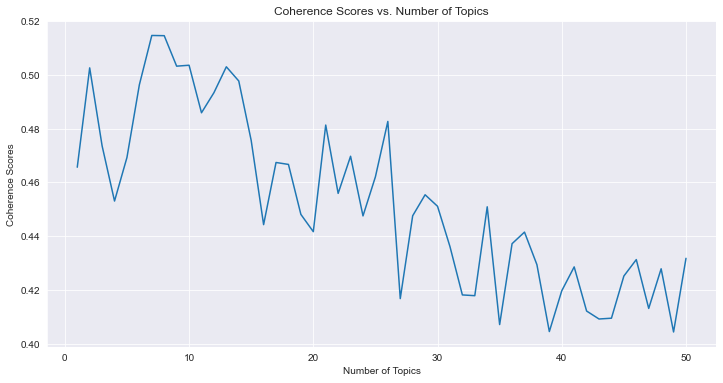

In [124]:
# Updated 4/11 
plt.figure(figsize=(12,6))
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
sns.lineplot(x=num_topics, y=coherence_scores)
plt.show()

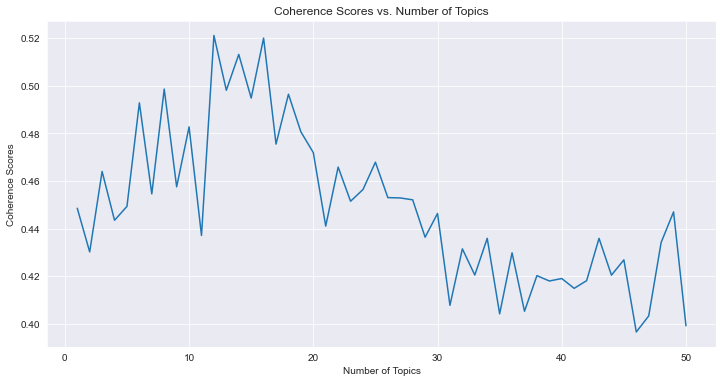

In [189]:
plt.figure(figsize=(12,6))
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
sns.lineplot(x=num_topics, y=coherence_scores)
plt.show()

In [128]:
pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)

,num_topics,coherence_score
6,7,0.514689
7,8,0.514609
9,10,0.503610
8,9,0.503264
12,13,0.503028
1,2,0.502632
13,14,0.497754
5,6,0.496361
11,12,0.493382
10,11,0.485917


In [129]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=7, random_state=123, passes=50)

In [130]:
lda_model.print_topics()

[(0,
  '0.029*"company" + 0.016*"employee" + 0.014*"work" + 0.010*"job" + 0.008*"get" + 0.007*"also" + 0.007*"people" + 0.007*"working" + 0.007*"help" + 0.006*"everyone"'),
 (1,
  '0.050*"great" + 0.034*"work" + 0.028*"company" + 0.027*"people" + 0.026*"culture" + 0.016*"employee" + 0.014*"team" + 0.012*"amazing" + 0.010*"fun" + 0.010*"environment"'),
 (2,
  '0.011*"benefit package" + 0.010*"bonus" + 0.009*"competitive salary" + 0.009*"benefit" + 0.009*"decent" + 0.008*"generous pto" + 0.007*"401k" + 0.007*"supportive management" + 0.005*"mom" + 0.005*"growth development"'),
 (3,
  '0.028*"good" + 0.016*"product" + 0.015*"company" + 0.010*"people" + 0.010*"team" + 0.008*"office" + 0.008*"culture" + 0.006*"lot" + 0.006*"great" + 0.005*"startup"'),
 (4,
  '0.009*"instructor" + 0.009*"training" + 0.007*"owner" + 0.006*"skill" + 0.005*"like family" + 0.005*"helpful" + 0.005*"senior management" + 0.005*"learn" + 0.004*"none" + 0.004*"entry level"'),
 (5,
  '0.012*"free food" + 0.011*"ping p

In [131]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, id2word)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.241046  0.006222       1        1  37.091505
0     -0.211851  0.190648       2        1  36.307635
3     -0.085451 -0.193926       3        1  10.960283
6     -0.080617 -0.089057       4        1   9.211056
4      0.211337  0.077884       5        1   3.031705
5      0.203845  0.016291       6        1   1.837161
2      0.203782 -0.008061       7        1   1.560655, topic_info=              Term         Freq        Total Category  logprob  loglift
12           great  3625.000000  3625.000000  Default  30.0000  30.0000
186           good  1074.000000  1074.000000  Default  29.0000  29.0000
1080             ’   629.000000   629.000000  Default  28.0000  28.0000
83         culture  2098.000000  2098.000000  Default  27.0000  27.0000
2628      training   796.000000   796.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
110        benefit    25.801496   769.174215   Topic7  -4.7262   0.7652
3441  good benefit    11.692766    98.582259   Topic7  -5.5177   2.0281
3762    also offer     7.423576    19.804013   Topic7  -5.9720   3.1788
3334           gym     7.295411    24.068487   Topic7  -5.9894   2.9664
476            pay     7.816245   352.477517   Topic7  -5.9204   0.3513

[448 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
15        2  0.996268    'm
16        1  0.108607   're
16        2  0.789604   're
16        3  0.099801   're
4844      7  0.831656  2019
...     ...       ...   ...
4315      3  0.967664     —
1080      4  0.998728     ’
1081      4  0.983847     “
1082      4  0.988009     ”
2689      1  0.973759     •

[708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 7, 5, 6, 3])

## TF-IDF

In [212]:
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,pros_cleaned,year,headline_cleaned
0,6sense,Love working here,2022-02-01,5.0,Frontend Developer,- Love working with my team\n- There's complet...,The meetings with US folks tend to go late at ...,love working team complete transparency compan...,2022,love working
1,6sense,Great Opportunity,2022-03-30,5.0,Technical Recruiter,Great mentorship opportunities and supportive ...,No cons. They are growing fast,great mentorship opportunity supportive team,2022,great opportunity
2,6sense,"Fantastic place to learn, grow, and be heard",2022-03-14,5.0,Demand Generation Manager,Where do I even begin? I felt like I was a par...,None that I can think of!,even begin felt like part family first day onb...,2022,fantastic place learn grow heard
3,6sense,Fantastic Company,2022-03-16,5.0,Tax,"Great people to work with, value employees' op...",None that I can say at this time.,great people work employee opinion skill exper...,2022,fantastic company
4,6sense,Love it!,2022-03-14,5.0,Corporate Event Marketing Specialist,- Great compensation\r\n- Amazing benefits\r\n...,- There are a few teams that are still being b...,great compensation amazing benefit wonderful e...,2022,love


### Pros Column Only 

In [219]:
X = df['pros_cleaned']
y = df['overall_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
print(X_train.shape)
print(y_train.shape)

(6321,)
(6321,)


In [220]:
scaler = StandardScaler(with_mean=False)

In [221]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tf_idf = vectorizer.fit_transform(X_train)
# X_train_tf_idf_scaled = scaler.fit_transform(X_train_tf_idf)
X_test_tf_idf = vectorizer.transform(X_test)
print(X_train_tf_idf.shape)
print(X_train.shape)
# (6321, 9428)
# 6321 reviews with 9428 unique words 

(6321, 10000)
(6321,)


In [222]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tf_idf, y_train)
y_hat_train = nb_classifier.predict(X_train_tf_idf)
y_hat_test = nb_classifier.predict(X_test_tf_idf)
print(f'Train Accuracy: {accuracy_score(y_train, y_hat_train)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_hat_test)}')

Train Accuracy: 0.7794652744818857
Test Accuracy: 0.7774086378737541


# Pros and Headline Column

In [273]:
# X_pros = df['pros_cleaned']
# X_headline = df['headline']
from scipy.sparse import csr_matrix

"""

"""
# TODO add scaling 
def split_data(df, features, target='overall_rating', test_size=0.3, vec_max_features=10000):
    
    X = df[features]
    y = df[target]
    
    #scaler = StandardScaler(with_mean=False)

    # train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
    
    X_train_final = pd.DataFrame()
    X_test_final = pd.DataFrame()
    
    # loop through features 
    for feature in features: 
        # Get X_train for just the feature column 
        X_train_current = X_train[feature]
        X_test_current = X_test[feature]
        
        # vectorizer 
        vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=vec_max_features)
        X_train_current_tfidf = pd.DataFrame(vectorizer.fit_transform(X_train_current).todense(), columns=vectorizer.get_feature_names())
        #X_train_current_tfidf_scaled = pd.DataFrame(scaler.fit_transform(X_train_current_tfidf.values), columns=X_train_current_tfidf.columns, index=X_train_current_tfidf.index)
        
        X_test_current_tfidf = pd.DataFrame(vectorizer.transform(X_test_current).todense(), columns=vectorizer.get_feature_names())
        #X_test_current_tfidf_scaled = pd.DataFrame(scaler.transform(X_test_current_tfidf.values), columns=X_test_current_tfidf.columns, index=X_test_current_tfidf.index)
        
        # add to combined dataframe 
        X_train_final = pd.concat([X_train_final, X_train_current_tfidf], axis=1)
        X_test_final = pd.concat([X_test_final, X_test_current_tfidf], axis=1)
    
    return X_train_final, X_test_final, y_train, y_test 



In [268]:
features = ['pros_cleaned']
X_train, X_test, y_train, y_test = split_data(df, features)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_hat_train = nb_classifier.predict(X_train)
y_hat_test = nb_classifier.predict(X_test)
print(f'Train Accuracy: {accuracy_score(y_train, y_hat_train)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_hat_test)}')

Train Accuracy: 0.7818383167220376
Test Accuracy: 0.7718715393133998


In [270]:
features = ['pros_cleaned','headline_cleaned']
X_train, X_test, y_train, y_test = split_data(df, features)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_hat_train = nb_classifier.predict(X_train)
y_hat_test = nb_classifier.predict(X_test)
print(f'Train Accuracy: {accuracy_score(y_train, y_hat_train)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_hat_test)}')

Train Accuracy: 0.7867426040183515
Test Accuracy: 0.7763012181616833


## Word2Vec

## Bert